## - Description - 

Bank wants to target clients that will subscribe to a term deposit.

For this project we will assume that domain knowledge consists of:
    the term deposit being a 2 year fixed term with a deposit of £10000,
    cost of targeting a client will £30,
    2.5% interest for client equalling £500,
    10% interest from borrowers equalling £1000,
    banks net interest income equalling £500,

Therefore we have; 
true positives (we contact client and they subscribe) with a benefit of £500 - £30 = £470,
false positives (we contact client and they dont subscribe) with a cost of £30,
true negatives (we dont contact client and they wouldnt have subscribed) with a benefit of 0,
false negatives (we dont contact client but they would have subscribed) with a cost of 0.. nothing spent nothing gained.
  
For this project we want to minimise profit loss (false negatives - not contacting clients that will subscribe) but also for the bank to save costs we want to minimise false positives (contacting clients and they don't subscribe).

The metric that we are going to use is f-beta with slightly more weighting towards recall as we want to minimise profit loss but also costs are important, Because the profit margin is fairly big we can focus more on profits than costs.

We will rank clients by probability of subscribing and target those that return the most profit. model for p(S|x) where S is a subscription and x is a client.

In [1]:
from eda import EDAToolkit
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mn
import itertools
from collections import deque
from scipy.stats import rankdata
from scipy.stats import chi2_contingency
from scipy.stats import kendalltau
from scipy.stats import pointbiserialr
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import kruskal
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway
from scipy.stats import boxcox
from scipy.spatial.distance import correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR, LinearSVR
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn import svm
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, SelectPercentile, mutual_info_regression
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from tqdm.notebook import trange
from mord import LogisticAT
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
import joblib
import multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool2
import dask.bag as db

eda = EDAToolkit()

Using TensorFlow backend.
C:\Users\jakee\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jakee\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jakee\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jakee\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
def chi2_corr(df, column):
    contingency = pd.crosstab(df[column], df['y'])
    print('{}: {}'.format(column, chi2_contingency(contingency)[0:3]))

In [3]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [4]:
# phi for dichotomous correlation
def phi(contingency_table):
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum()
    return np.sqrt(chi2 / n)

In [5]:
def cramers_corrected_stat(contingency_table):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum()
    phi2 = chi2/n
    r,k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [6]:
def cv_score(model, features, target, model_list, score_list, std_list, cv = 5):
    """ 
    trains model using cross validation for classification
    score_dict = dict for storing models average scoring metric
    std_dict = dict for storing models standard deviation
    """
    #if scoring == 'accuracy':
    acc = cross_val_score(model, features, target, n_jobs = -1, cv = cv, scoring = 'accuracy')
    #score_dict[model] = np.mean(acc)
    #std_dict[model] = np.std(acc)
    model_list.append(model)
    score_list.append(np.mean(acc))
    std_list.append(np.std(acc))

    #if summary:
    #print_summary(model, score_dict, std_dict)
        
    

In [7]:
def print_summary(model, score_dict, std_dict):
    print('\nModel:\n', model)
    print('\nAverage Accuracy:\n', score_dict[model])
    print('\nStandard Deviation during CV:\n', std_dict[model])

In [8]:
## multiprocess function    
def best_subset_multiprocess(features, target, partition_size = 5000):
    """
                !!WARNING DOES NOT SHOW PROGRESS!!
    
    MAY TAKE A VERY LONG TIME DEPENDING ON NUMBER OF FEATURES
                    AND NUMBER OF OBSERVATIONS
                    
    Performs multiprocess of best subset procedure using total cores - 1
    
    params:
        features = features to perform best subset procedure on
        target = depependent/target variable from data
        partition_size = size of partitions for feature combinations
                1 = no partition (WARNING: may crash due to memory)
                5000 starting place, test on small part of feature 
                combinations and play with this no. for optimal
                performance
    
    returns:
        dataframe with best features for each no. of combinations
    """
    def feature_combinations():
        """
        returns:
            list containing lists for each no. of feature combinations
            e.g. [[1 feature combos],[2 feature combos]..[k feature combos]]
        """
        entire_combinations = []
        for i in range(1, len(features.columns) + 1):
            combination_list = []
            for combo in itertools.combinations(features.columns, i):
                combination_list.append(list(combo))
            entire_combinations.append(combination_list)
        return entire_combinations
    
    def timed(seconds):
        """
        converts timed seconds into days:mins:hours:secs
        params:
            seconds = total time taken in seconds

        returns:
            string(days:hours:mins:secs)
        """
        secs_in_day = 86400
        secs_in_hr = 3600
        secs_in_min = 60
        day_float = seconds / secs_in_day
        days = int(day_float // 1)
        day_dec = day_float % 1
        hrs_in_secs = day_dec * secs_in_day
        hr_float = hrs_in_secs / secs_in_hr
        hours = int(hr_float // 1)
        hr_dec = hr_float % 1
        mins_in_secs = hr_dec * secs_in_hr
        min_float = mins_in_secs / secs_in_min
        minutes = int(min_float // 1)
        min_dec = min_float % 1
        sec_float = min_dec * secs_in_min
        seconds = int(sec_float // 1)
        sec_dec = sec_float % 1
        if sec_dec > 0.5:
            seconds += 1
        if days == 0 and hours == 0 and minutes == 0:
            return f'{seconds}s'
        elif days == 0 and hours == 0:
            return f'{minutes}m:{seconds}s'
        elif days == 0:
            return f'{hours}h:{minutes}m:{seconds}s'
        else:
            return f'{days}d:{hours}h:{minutes}m:{seconds}s'
    
    def s_dframe(feat):
        """
        mapping function
        returns:
            dataframe from feature combination inc. target
        """
        import pandas as pd
        dframe = pd.DataFrame(features[feat])
        dframe['target'] = target
        return dframe
    
    def s_train(combo):
        """
        mapping function
        returns:
            list [no. of features from combination, 
                  accuracy of feature combination,
                  features from combination]
        """
        from sklearn.utils import shuffle
        #from sklearn.naive_bayes import GaussianNB
        from sklearn.linear_model import LogisticRegression
        #import numpy as np
        model = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced')
        features = combo.iloc[:,:-1]
        target = combo.iloc[:,-1]
        #accs = []
        #for i in range(3):
        shuff_features, shuff_target = shuffle(features, target, random_state = 42)
        train_feats = shuff_features[:30000]
        test_feats = shuff_features[30000:]
        train_targ = shuff_target[:30000]
        test_targ = shuff_target[30000:]
        model.fit(train_feats, train_targ)
        accuracy = model.score(test_feats, test_targ)
            #accs.append(accuracy)
        cols = list(features.columns)
        cols = ','.join(cols)

        top_feats = [len(features.columns), accuracy, cols]

        return top_feats
    
    def s_dframe_partitions(combo_list):
        """ 
        splits combo list into partitions
        returns list of lists containing partitions
        """
        from collections import deque
        combo_partition_list = deque([combo_list[i * partition_size:(i + 1) * partition_size] for i in range((len(combo_list) + partition_size - 1) // partition_size )]) 
        return combo_partition_list
    
    def feature_combination_process(feature_combinations):
        """
        multiprocess mapping function
        returns:
            best features list
            [num features, accuracy, features]
        """
        import pandas as pd
        from collections import deque
        combo_partition_list = s_dframe_partitions(feature_combinations)
        top_acc = None
        for partition in combo_partition_list:
            subset_dfs = deque([map(s_dframe, partition)]) 
            top_feats = deque([map(s_train, subset_dfs[0])])  
            tf = pd.DataFrame(top_feats[0], columns = ['Num Features','Accuracy','Features'])
            # get top accuracy from dataframe
            top = tf.groupby(['Num Features'])['Accuracy'].transform(max) == tf['Accuracy']
            # select just the best row containing top accuracy
            best_feats = tf[top]
            #if len(best_feats) > 5:
                #best_feats = pd.DataFrame(best_feats.iloc[0:5,:])
            if top_acc is not None:
                if max(best_feats['Accuracy']) > max(top_acc['Accuracy']):
                    top_acc = best_feats.copy()
                elif max(best_feats['Accuracy']) == max(top_acc['Accuracy']):
                    top_acc.append(best_feats)
            else:
                top_acc = best_feats.copy()
        # limit df size to 50
        if len(top_acc) > 50:
            top_acc = top_acc.iloc[0:50, :]
        #list(top_acc.values.tolist())
        return top_acc

    
    from datetime import datetime
    
    start = time.time()
    
    print('Processing Data....')
    combo_split = feature_combinations() 
    test_combos = combo_split[0:7] #### for testing only ####
    print(f'\n{len(test_combos)} Total Feature Combinations') ### change if testing
    current_time = datetime.now().time().strftime("%H:%M")
    print(f'\n    Starting best subset at {current_time}....\n')
    # multiprocess
    cores = mp.cpu_count() - 1
    pool = Pool2(cores)
    top_features = deque([pool.map(feature_combination_process, test_combos)]) ### change if testing
    pool.close()
    pool.join()
    pool.clear()
    # create df and return sorted df
    #top_feat_df = pd.DataFrame(top_features[0], columns = ['Num Features', 'Accuracy', 'Features'])
    top_feat_df = pd.concat(top_features[0])
    end = time.time()          
    total_time = timed(end - start)
    finish_time = datetime.now().time().strftime("%H:%M")
    print(f'....Finished best subset at: {finish_time}\n\nTotal time taken: {total_time}')
    return top_feat_df.sort_values(by = 'Accuracy', ascending = False).reset_index(drop = True)


In [9]:
def best_subset(model, features, target):
    """ 
    indicates which features to use for optimal model based on accuracy
    scores
    
    non multiprocess
    
    returns:
        dataframe with features and scores 
    """
    def timed(seconds):
        """
        converts timed seconds into days:mins:hours:secs
        params:
            seconds = total time taken in seconds

        returns string(days:hours:mins:secs)
        """
        secs_in_day = 86400
        secs_in_hr = 3600
        secs_in_min = 60
        day_float = seconds / secs_in_day
        days = int(day_float // 1)
        day_dec = day_float % 1
        hrs_in_secs = day_dec * secs_in_day
        hr_float = hrs_in_secs / secs_in_hr
        hours = int(hr_float // 1)
        hr_dec = hr_float % 1
        mins_in_secs = hr_dec * secs_in_hr
        min_float = mins_in_secs / secs_in_min
        minutes = int(min_float // 1)
        min_dec = min_float % 1
        sec_float = min_dec * secs_in_min
        seconds = int(sec_float // 1)
        sec_dec = sec_float % 1
        if sec_dec > 0.5:
            seconds += 1
        if days == 0 and hours == 0 and minutes == 0:
            return f'{seconds}s'
        elif days == 0 & hours == 0:
            return f'{minutes}m:{seconds}s'
        elif days == 0:
            return f'{hours}h:{minutes}m:{seconds}s'
        else:
            return f'{days}d:{hours}h:{minutes}m:{seconds}s'
    
    def model_acc(model, features, target):
        """ fits classification model and returns accuracy value """
        clf_model = model
        train_feats = features[:30000]
        test_feats = features[30000:]
        train_targ = target[:30000]
        test_targ = target[30000:]
        clf_model.fit(train_feats, train_targ)
        acc = clf_model.score(test_feats, test_targ)
        return acc
    
    num_feats = features.shape[1]
    print(f'Total of {num_feats} Feature Combinations')
    
    top_features = pd.DataFrame(columns = ['Num Features', 'Accuracy', 'Features'])
    # loop over features
    start = time.time()
    print('\nStarting Best Subset...')
    for k in tnrange(1, 6 + 1, desc = 'Feature Combinations...'): # len(features.columns)
        print(f'{k} Feature Combinations....')
        acc_list = deque([])
        feature_list = deque([])
        num_features = deque([])
        subset_start = time.time()
        # loop over all possible combinations
        for combo in itertools.combinations(features.columns, k):
            # store temp result
            accuracy = model_acc(model, features[list(combo)], target)
            # append lists
            acc_list.append(accuracy)
            feature_list.append(combo)
            num_features.append(len(combo))
        # store in dataframe
        df = pd.DataFrame({'Num Features': num_features, 
                           'Accuracy': acc_list, 
                           'Features': feature_list})
        top = df.groupby(['Num Features'])['Accuracy'].transform(max) == df['Accuracy']
        best_feats = df[top]
        if len(best_feats) > 1:
            top_features = top_features.append(best_feats.iloc[0,:])
        else:
            top_features = top_features.append(best_feats) 
        subset_end = time.time()
        subset_time = timed(subset_end - subset_start)
        print(f'                         Time Taken: {subset_time}')
    end = time.time()
    finish_time = timed(end - start)
    print(f'Finished best subset\n\nTotal time taken: {finish_time}')

    return top_features.sort_values(by = 'Accuracy', ascending = False)

In [2]:
def expected_value(c_matrix, cb_matrix, dec_place = 2):
    """
    params:
        c_matrix = confusion matrix
        cb_matrix = cost benefit matrix
        dec_place = no. of decimals to be displayed
        
    returns expected value
    """
    # cost matrix errors
    cb_tp = cb_matrix[1][1]
    cb_fp = cb_matrix[0][1]
    cb_tn = cb_matrix[0][0]
    cb_fn = cb_matrix[1][0]
    # confusion matrix errors
    tp = c_matrix[1][1]
    fp = c_matrix[0][1]
    tn = c_matrix[0][0]
    fn = c_matrix[1][0]
    # confusion matrix totals
    total = np.sum([tp,fn,tn,fp])
    tot_pos = np.sum([tp,fn])
    tot_neg = np.sum([tn,fp])
    # confusion matrix class priors
    prob_pos = np.round((tot_pos / total), 2)
    prob_neg = np.round((tot_neg / total), 2)
    # confusion matrix error rates
    tp_rate = np.round((tp / tot_pos), 2)
    fn_rate = np.round((fn / tot_pos), 2)
    tn_rate = np.round((tn / tot_neg), 2)
    fp_rate = np.round((fp / tot_neg), 2)
    # expected value
    pos_val = prob_pos * (tp_rate * cb_tp + fn_rate * cb_fn) 
    neg_val = prob_neg * (tn_rate * cb_tn + fp_rate * cb_fp)
    exp_val = np.round((pos_val + neg_val), dec_place)
    return exp_val

In [11]:
def f2(y_true, y_pred):
    """f-beta that adds more weight to recall"""
    return fbeta_score(y_true, y_pred, beta = 1.5)

In [12]:
def evaluate_model(features, target, model):
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    # evaluation scoring metric
    metric = make_scorer(f2)
    scores = cross_val_score(model, features, target, scoring = metric, cv = cv, n_jobs = -1)
    return scores

In [13]:
def data_preprocess(dataframe):
    # split dataframe into features and target
    target = dataframe.iloc[:,-1].copy()
    features = dataframe.iloc[:, :-1].copy()
    # encode features and target
    target.replace(to_replace = ['yes', 'no'], value = [1, 0], inplace = True)
    # select categorical and numerical features
    cat_idx = features.select_dtypes(include = ['object', 'bool']).columns
    num_idx = features.select_dtypes(include = ['int64', 'float64']).columns
    return features, target, cat_idx, num_idx

In [14]:
def load_data(dataframe):
    # split dataframe into features and target
    target = dataframe.iloc[:,-1].copy()
    features = dataframe.iloc[:, :-1].copy()
    # encode features and target
    target.replace(to_replace = ['yes', 'no'], value = [1, 0], inplace = True)
    return features, target

In [15]:
def get_ml_models():
    """ models for testing """
    models, names = list(), list()
    
    models.append(LogisticRegression(solver = 'liblinear', class_weight = 'balanced', n_jobs = -1))
    names.append('LR')
    
    models.append(SVC(class_weight = 'balanced', gamma = 'scale'))
    names.append('SVC')
    
    models.append(KNeighborsClassifier(n_neighbors = 5, n_jobs = -1))
    names.append('KNN')
    
    models.append(DecisionTreeClassifier(class_weight = 'balanced', max_features = 'sqrt'))
    names.append('DT')
    
    models.append(RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', max_features = 'sqrt', n_jobs = -1, verbose = 1))
    names.append('RF')
    
    models.append(GradientBoostingClassifier(n_estimators = 100, max_features = 'sqrt', verbose = 1))
    names.append('GB')
    
    models.append(AdaBoostClassifier(n_estimators = 50))
    names.append('AB')
    
    models.append(GaussianNB())
    names.append('GNB')
    
    models.append(BernoulliNB())
    names.append('BNB')
    
    return models, names

In [16]:
def get_us_models():
    """ undersamplng models """
    models, names = list(), list()
    
    models.append(TomekLinks())
    names.append('TL')
    
    models.append(EditedNearestNeighbours())
    names.append('ENN')
    
    models.append(RepeatedEditedNearestNeighbours())
    names.append('RENN')
    
    models.append(OneSidedSelection())
    names.append('OSS')
    
    models.append(NeighbourhoodCleaningRule())
    names.append('NCR')
    
    models.append(InstanceHardnessThreshold())
    names.append('IHT')
    
    models.append(SMOTEENN(enn = EditedNearestNeighbours(sampling_strategy = 'majority')))
    names.append('S(ENN)')
        
    return models, names

In [17]:
def get_os_models():
    """ oversampling models """
    models, names = list(), list()
    
    models.append(SMOTE(sampling_strategy = 0.2))
    names.append('S')
    
    models.append(BorderlineSMOTE())
    names.append('BS')
    
    models.append(SVMSMOTE())
    names.append('SVMS')
    
    models.append(ADASYN())
    names.append('AS')
        
    return models, names

In [18]:
def baseline_preprocess(dataframe):
    # split dataframe into features and target
    target = dataframe.iloc[:,-1].copy()
    features = dataframe.iloc[:, :-1].copy()
    # encode features and target
    target.replace(to_replace = ['yes', 'no'], value = [1, 0], inplace = True)
    # select categorical features and transform
    features = pd.get_dummies(features, drop_first = True)
    sc = StandardScaler(with_mean = False)
    features = sc.fit_transform(features)
    #cats = features.select_dtypes(include = ['object', 'bool']).columns
    #ct = ColumnTransformer([('o', OneHotEncoder(), cats)], remainder = 'passthrough')
    return features, target

In [19]:
def sequential_forward_feature_selection(model, dataframe, sampling = None, combined_sampling = None):
    """ Classification """
    
    feats, targ = load_data(dataframe)
    feats, targ = shuffle(feats, targ, random_state = 42)
    remaining_features = list(feats.columns)
    feature_list = []
    best_subfeat_scores = None
    best_score = None
    for i in trange(1, len(feats.columns) + 1, desc = 'Feature round...'):
        #print(f'\nremaining features: {remaining_features}\n')
        top_round_feat = None
        top_round_scores = None
        for rf in remaining_features:
            # select features to score & one hot encode
            if len(feature_list) == 0:
                sub_feats = feats[rf]
                if sub_feats.dtype == 'O':
                    sub_feats = pd.get_dummies(sub_feats)
                else:
                    sub_feats = np.array(sub_feats).reshape(-1,1)
            else:
                sub_feats = pd.concat([feats[feature_list], feats[rf]], axis = 1)
                if 'O' in sub_feats.dtypes.tolist():
                    sub_feats = pd.get_dummies(sub_feats)
              
            # initiate pipeline - scale, sampling - if needed, model
            if sampling is not None and combined_sampling is None:
                pipe = Pipeline(
                    steps = [
                        ('scaler', StandardScaler(with_mean = False)),
                        ('sampling', sampling),
                        ('model', model)
                    ]
                )
            elif sampling is not None and combined_sampling is not None:
                pipe = Pipeline(
                    steps = [
                        ('scaler', StandardScaler(with_mean = False)),
                        ('sampling', sampling),
                        ('combo sampling', combined_sampling),
                        ('model', model)
                    ]
                )
            else:
                pipe = Pipeline(
                    steps = [
                        ('scaler', StandardScaler(with_mean = False)),
                        ('model', model)
                    ]
                )
            # evaluate sub_feats with model
            scores = evaluate_model(sub_feats, targ, pipe)
            current_score = np.mean(scores)
            # assert (current_score == np.nan), f'Model evaluation: {current_score}\nFunction will not work correctly if a subset feature score is nan, check terminal or increase verbosity of cv to find where the problem is'  ######
            # keep best score, feature & scores
            if best_score is not None:
                if current_score > best_score:
                    best_score = current_score
                    top_round_feat = rf
                    top_round_scores = scores
                else:
                    continue
            else:
                best_score = current_score
                top_round_feat = rf
                top_round_scores = scores
            
            #print(f'top round feat: {top_round_feat}')
            #print(f'best score: {best_score}')
                
        # update best scores
        if top_round_scores is not None:
            best_subfeat_scores = top_round_scores
        # update best features
        if top_round_feat is not None:
            feature_list.append(top_round_feat)
            # remove best round feature from next round
            remaining_features.remove(top_round_feat)
        else:
            # if no feature improved the model we break and finish
            print('Optimal features reached......\n\n')
            break 
          
    # print model, best features, score and standard deviation
    print(f'{model}\n\nBest Features:\n{feature_list}\n\nScore: {np.mean(best_subfeat_scores)}        Std: {np.std(best_subfeat_scores)}')

In [58]:
def exp_equation(classif_prob, deposit_val, reg_call_val):
    # p(S|x) * (dv - vc(x)) + (1 - p(S|x)) * - vc(x)
    value = classif_prob * (deposit_val - reg_call_val) + (1 - classif_prob) * - reg_call_val
    return value

In [59]:
def get_classif_models():
    models, names = list(), list()
    models.append(
        GradientBoostingClassifier(
            learning_rate = 0.05, 
            n_estimators = 60, 
            max_depth = 11,
            min_samples_split = 1200,
            min_samples_leaf = 50,
            max_features = 3,
            subsample = 1.0,
            random_state = 42
        )
    )
    names.append('GB')
    models.append(AdaBoostClassifier(algorithm = 'SAMME.R', learning_rate = 0.1, n_estimators = 1200, random_state = 42))
    names.append('AB')
    gb = GradientBoostingClassifier(
        learning_rate = 0.05,
        n_estimators = 250,
        max_depth = 9,
        min_samples_split = 1500,
        min_samples_leaf = 140,
        max_features = 3,
        subsample = 0.8,
        random_state = 42
    )
    ab = AdaBoostClassifier(
        algorithm = 'SAMME.R',
        learning_rate = 0.75,
        n_estimators = 450,
        random_state = 42
    )
    models.append(VotingClassifier([('gb', gb), ('ab', ab)], voting = 'soft', n_jobs = -1))
    names.append('VC(GBAB)')
    models.append(LogisticRegression(solver = 'liblinear', class_weight = 'balanced'))
    names.append('SM LR')
    models.append(SVC(kernel = 'rbf', C = 0.4, gamma = 'auto', probability = True))
    names.append('SVC')
    return models, names

In [60]:
def get_sampling_models():
    svms = SVMSMOTE()
    smote = SMOTE(sampling_strategy = 0.4, k_neighbors = 11)
    rus = RandomUnderSampler(sampling_strategy = 0.6)
    vc_smote = SMOTE(sampling_strategy = 0.4, k_neighbors = 5)
    return svms, smote, rus, vc_smote

In [61]:
def get_optimal_model_features(classif_features):
    gb_feats = classif_features[
        [
            'age_bin',
            'cons.price.idx',  
            'euribor3m',
            'season_sin',
            'season_cos' 
        ]
    ]
    ab_feats = classif_features[
        [
            'age_bin', 
            'poutcome',
            'cons.conf.idx',
            'season_sin',
            'season_cos'
        ]
    ]
    vc_feats = classif_features[
        [
            'age_bin',  
            'previous', 
            'poutcome', 
            'emp.var.rate',
            'euribor3m', 
            'nr.employed',  
            'season_sin', 
            'season_cos',
        ]
    ]
    sm_lr_feats = classif_features[['nr.employed']]
    #dt_feats = reg_features[
    #    [
    #        'euribor3m', 
    #        'cons.price.idx'
    #    ]
    #]
    svc_feats = classif_features
    return gb_feats, ab_feats, vc_feats, sm_lr_feats, svc_feats

In [20]:
# load/split data
dataframe = pd.read_csv('bank-additional-full.csv', delimiter = ';')
data_feats, hold_feats, data_targ, hold_targ = train_test_split(
    dataframe.iloc[:, :-1], 
    dataframe.iloc[:, -1], 
    test_size = 0.1, 
    stratify = dataframe.iloc[:, -1],
    random_state = 42
)
data = pd.concat([data_feats, data_targ], axis = 1)
hold_data = pd.concat([hold_feats, hold_targ], axis = 1)
hold_data_reg = hold_data.copy()

In [21]:
# columns explained
"""
default: has credit in default
housing: has housing loan
loan: has personal loan
contact: contact communication type
month: last contact month of year
day_of_week: last contact day of the week 
duration: last contact duration, in seconds.. this attribute highly affects the output target (e.g., if duration=0 then y="no")
campaign: number of contacts performed during this campaign and for this client
pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
previous: number of contacts performed before this campaign and for this client
poutcome: outcome of the previous marketing campaign
emp.var.rate: employment variation rate - quarterly indicator 
cons.price.idx: consumer price index - monthly indicator    
cons.conf.idx: consumer confidence index - monthly indicator      
euribor3m: euribor 3 month rate - daily indicator
nr.employed: number of employees - quarterly indicator

y: has the client subscribed a term deposit
"""

'\ndefault: has credit in default\nhousing: has housing loan\nloan: has personal loan\ncontact: contact communication type\nmonth: last contact month of year\nday_of_week: last contact day of the week \nduration: last contact duration, in seconds.. this attribute highly affects the output target (e.g., if duration=0 then y="no")\ncampaign: number of contacts performed during this campaign and for this client\npdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)\nprevious: number of contacts performed before this campaign and for this client\npoutcome: outcome of the previous marketing campaign\nemp.var.rate: employment variation rate - quarterly indicator \ncons.price.idx: consumer price index - monthly indicator    \ncons.conf.idx: consumer confidence index - monthly indicator      \neuribor3m: euribor 3 month rate - daily indicator\nnr.employed: number of employees - quarterly indica

In [22]:
data.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
8061,52,technician,divorced,professional.course,unknown,yes,no,telephone,jun,mon,...,8,999,0,nonexistent,1.4,94.465,-41.8,4.865,5228.1,no
25300,36,management,married,university.degree,no,yes,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
17667,53,blue-collar,married,high.school,no,yes,yes,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
37400,45,blue-collar,single,basic.9y,no,yes,no,cellular,aug,wed,...,1,4,1,success,-2.9,92.201,-31.4,0.879,5076.2,no
4629,60,housemaid,married,high.school,unknown,yes,no,telephone,may,wed,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no


## -- Clean Data ---

In [23]:
# check missing values
for col in data:
    vals = pd.isnull(data[col])
    missing_vals = data[vals].index
    if len(missing_vals) == 0:
        print('{}: No Missing Values'.format(col))
    else:
        print('{}: {}'.format(col, missing_vals))


age: No Missing Values
job: No Missing Values
marital: No Missing Values
education: No Missing Values
default: No Missing Values
housing: No Missing Values
loan: No Missing Values
contact: No Missing Values
month: No Missing Values
day_of_week: No Missing Values
duration: No Missing Values
campaign: No Missing Values
pdays: No Missing Values
previous: No Missing Values
poutcome: No Missing Values
emp.var.rate: No Missing Values
cons.price.idx: No Missing Values
cons.conf.idx: No Missing Values
euribor3m: No Missing Values
nr.employed: No Missing Values
y: No Missing Values


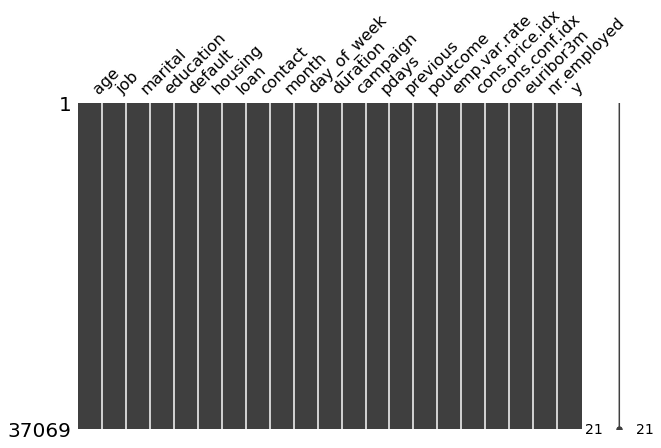

In [24]:
# visual for missing values
mn.matrix(data, figsize = (10,6))

Although we have no missing values there are some unknown values for some categorical data. We can treat these as either another categorical class, use imputation or remove them.

In [25]:
# check for unknowns
for col in data:
    if data[col].dtype == 'O':
        if 'unknown' in data[col].value_counts():
            unknowns = data[col].value_counts()['unknown']
            print('{}: {} unknowns'.format(col, unknowns))
        else:
            print('{}: 0 unknowns'.format(col))

job: 296 unknowns
marital: 69 unknowns
education: 1564 unknowns
default: 7773 unknowns
housing: 893 unknowns
loan: 893 unknowns
contact: 0 unknowns
month: 0 unknowns
day_of_week: 0 unknowns
poutcome: 0 unknowns
y: 0 unknowns


In [26]:
# show duplicated data
duplicates = data.duplicated()
duplicated_entries = np.array(duplicates[duplicates].index)
data.loc[duplicated_entries,:]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
38255,71,retired,single,university.degree,no,no,no,telephone,oct,tue,...,1,999,0,nonexistent,-3.4,92.431,-26.9,0.742,5017.5,no


In [27]:
# remove duplicated entries
data.drop(index = duplicated_entries, inplace = True)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37061 entries, 8061 to 10747
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             37061 non-null  int64  
 1   job             37061 non-null  object 
 2   marital         37061 non-null  object 
 3   education       37061 non-null  object 
 4   default         37061 non-null  object 
 5   housing         37061 non-null  object 
 6   loan            37061 non-null  object 
 7   contact         37061 non-null  object 
 8   month           37061 non-null  object 
 9   day_of_week     37061 non-null  object 
 10  duration        37061 non-null  int64  
 11  campaign        37061 non-null  int64  
 12  pdays           37061 non-null  int64  
 13  previous        37061 non-null  int64  
 14  poutcome        37061 non-null  object 
 15  emp.var.rate    37061 non-null  float64
 16  cons.price.idx  37061 non-null  float64
 17  cons.conf.idx   37061 non-nu

In [29]:
# continuous outlier check
for col in data:
    if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        stats = data[col].describe()
        IQR = stats['75%'] - stats['25%']
        upper = stats['75%'] + 1.5 * IQR
        lower = stats['25%'] - 1.5 * IQR
        #print('The bounds for potential outliers are; \nUpper Bound: {} \nLower Bound: {}'.format(upper, lower))
        
        lower_bound_outliers = data[data[col] < lower]
        upper_bound_outliers = data[data[col] > upper]
        print('{}: {} upper outliers and {} lower outliers, bounds: upper bound = {}, lower bound = {}\n'.format(col, len(upper_bound_outliers), len(lower_bound_outliers), upper, lower))

age: 412 upper outliers and 0 lower outliers, bounds: upper bound = 69.5, lower bound = 9.5

duration: 2665 upper outliers and 0 lower outliers, bounds: upper bound = 643.0, lower bound = -221.0

campaign: 2164 upper outliers and 0 lower outliers, bounds: upper bound = 6.0, lower bound = -2.0

pdays: 0 upper outliers and 1379 lower outliers, bounds: upper bound = 999.0, lower bound = 999.0

previous: 5080 upper outliers and 0 lower outliers, bounds: upper bound = 0.0, lower bound = 0.0

emp.var.rate: 0 upper outliers and 0 lower outliers, bounds: upper bound = 6.200000000000001, lower bound = -6.6000000000000005

cons.price.idx: 0 upper outliers and 0 lower outliers, bounds: upper bound = 95.3725, lower bound = 91.69650000000001

cons.conf.idx: 395 upper outliers and 0 lower outliers, bounds: upper bound = -26.949999999999992, lower bound = -52.150000000000006

euribor3m: 0 upper outliers and 0 lower outliers, bounds: upper bound = 10.3865, lower bound = -4.081499999999999

nr.employed

In [30]:
# dependent variable class balance
data.y.value_counts()

no     32885
yes     4176
Name: y, dtype: int64

outliers in numerical data are important to keep, y variable is extremely unbalanced.

In [31]:
# create copy of data without duration feature as this feature indicates 
# that the client has or has not subscribed a term deposit.. at the end of the call the outcome is known
df = data.iloc[:, [0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20]]
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
8061,52,technician,divorced,professional.course,unknown,yes,no,telephone,jun,mon,8,999,0,nonexistent,1.4,94.465,-41.8,4.865,5228.1,no
25300,36,management,married,university.degree,no,yes,no,cellular,nov,tue,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
17667,53,blue-collar,married,high.school,no,yes,yes,cellular,jul,mon,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
37400,45,blue-collar,single,basic.9y,no,yes,no,cellular,aug,wed,1,4,1,success,-2.9,92.201,-31.4,0.879,5076.2,no
4629,60,housemaid,married,high.school,unknown,yes,no,telephone,may,wed,1,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no


## -- EDA --

In [32]:
# sort variables into categorical and numerical
cat_var, num_var = eda.cat_num_sort(df.iloc[:, :-1])
print('Catagorical variables: {}\nNumerical variables: {}'.format(cat_var, num_var))

Catagorical variables: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Numerical variables: ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [33]:
"""
categorical type:

job: nominal
marital: nominal
education: ordinal
default: nomnal
housing: nominal
loan: nominal
contact: dichotomous
month: cyclical
day_of_week: cyclical
poutcome: nominal

y: dichotomous
"""

'\ncategorical type:\n\njob: nominal\nmarital: nominal\neducation: ordinal\ndefault: nomnal\nhousing: nominal\nloan: nominal\ncontact: dichotomous\nmonth: cyclical\nday_of_week: cyclical\npoutcome: nominal\n\ny: dichotomous\n'

In [34]:
# variable type
cont_cat = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
ord_cat = ['education']
dich_cat = ['contact', 'y']
nom_cat = ['job', 'marital', 'default', 'housing', 'loan', 'poutcome']
cyclical_cat = ['month', 'day_of_week']

In [35]:
# categorical summary
df.describe(include = ['O'])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,37061,37061,37061,37061,37061,37061,37061,37061,37061,37061,37061
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,9362,22418,10964,29286,19429,30510,23510,12422,7732,31981,32885


In [36]:
# numerical summary
df.describe(include = [np.number])

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,37061.000000,37061.000000,37061.000000,37061.000000,37061.000000,37061.000000,37061.000000,37061.000000,37061.000000
mean,40.022342,2.567038,962.050215,0.173983,0.082202,93.576453,-40.505958,3.620432,5166.963887
std,10.412122,2.765852,187.959191,0.497488,1.570975,0.578592,4.623267,1.735321,72.360638
min,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


age Anderson-Darling test:
Test Statistic: 395.68224095823825    Critical Values: [0.576 0.656 0.787 0.918 1.092]    Significance: [15.  10.   5.   2.5  1. ]


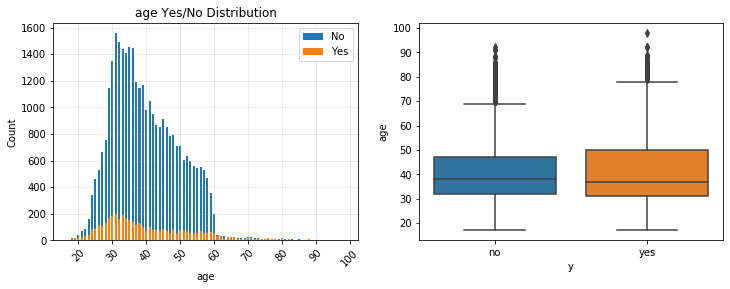

Subscription Confidence Intervals for job Classes at 95% Confidence:
entrepreneur confidence interval:    Subscribed (0.0703, 0.1006) Non Subscribed (0.8994, 0.9297)
self-employed confidence interval:    Subscribed (0.0887, 0.1227) Non Subscribed (0.8773, 0.9113)
blue-collar confidence interval:    Subscribed (0.0628, 0.0736) Non Subscribed (0.9264, 0.9372)
unemployed confidence interval:    Subscribed (0.1229, 0.1689) Non Subscribed (0.8311, 0.8771)
student confidence interval:    Subscribed (0.285, 0.3493) Non Subscribed (0.6507, 0.715)
housemaid confidence interval:    Subscribed (0.0795, 0.1175) Non Subscribed (0.8825, 0.9205)
admin. confidence interval:    Subscribed (0.1232, 0.1368) Non Subscribed (0.8632, 0.8768)
retired confidence interval:    Subscribed (0.2318, 0.2754) Non Subscribed (0.7246, 0.7682)
unknown confidence interval:    Subscribed (0.0815, 0.155) Non Subscribed (0.845, 0.9185)
technician confidence interval:    Subscribed (0.1002, 0.1158) Non Subscribed (0.8842, 0

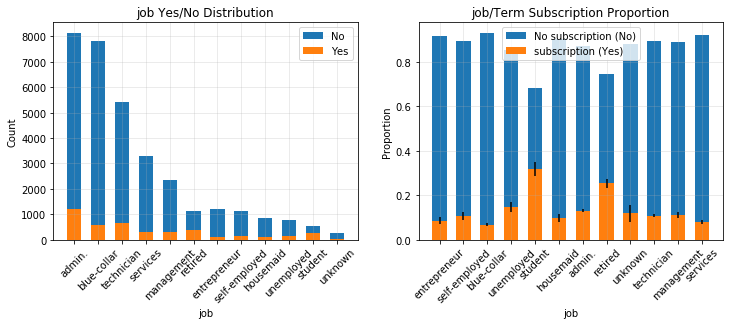

Subscription Confidence Intervals for marital Classes at 95% Confidence:
single confidence interval:    Subscribed (0.1331, 0.1464) Non Subscribed (0.8536, 0.8669)
married confidence interval:    Subscribed (0.0978, 0.1057) Non Subscribed (0.8943, 0.9022)
divorced confidence interval:    Subscribed (0.0935, 0.112) Non Subscribed (0.888, 0.9065)
unknown confidence interval:    Subscribed (0.073, 0.2458) Non Subscribed (0.7542, 0.927)


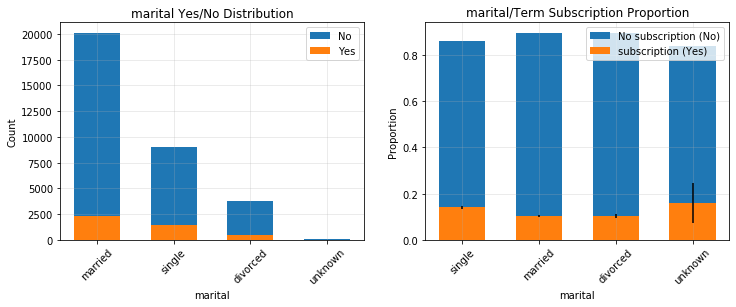

Subscription Confidence Intervals for education Classes at 95% Confidence:
high.school confidence interval:    Subscribed (0.1015, 0.1147) Non Subscribed (0.8853, 0.8985)
unknown confidence interval:    Subscribed (0.1272, 0.162) Non Subscribed (0.838, 0.8728)
illiterate confidence interval:    Subscribed (0.0337, 0.4369) Non Subscribed (0.5631, 0.9663)
basic.4y confidence interval:    Subscribed (0.092, 0.1113) Non Subscribed (0.8887, 0.908)
basic.9y confidence interval:    Subscribed (0.0693, 0.0834) Non Subscribed (0.9166, 0.9307)
basic.6y confidence interval:    Subscribed (0.0703, 0.094) Non Subscribed (0.906, 0.9297)
university.degree confidence interval:    Subscribed (0.1317, 0.1446) Non Subscribed (0.8554, 0.8683)
professional.course confidence interval:    Subscribed (0.1056, 0.1238) Non Subscribed (0.8762, 0.8944)


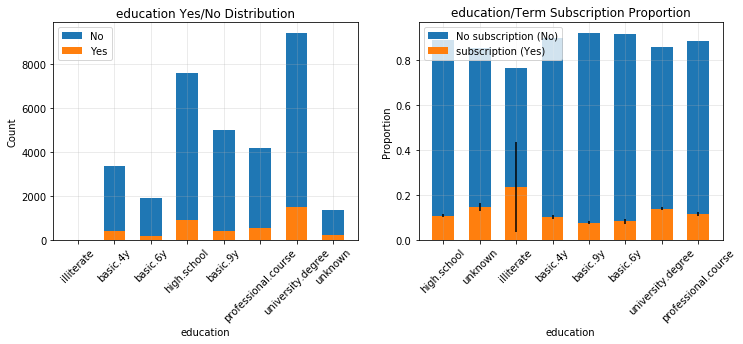

Subscription Confidence Intervals for default Classes at 95% Confidence:
no confidence interval:    Subscribed (0.125, 0.1326) Non Subscribed (0.8674, 0.875)
yes confidence interval:    Subscribed (0.0, 0.0) Non Subscribed (1.0, 1.0)
unknown confidence interval:    Subscribed (0.047, 0.0569) Non Subscribed (0.9431, 0.953)


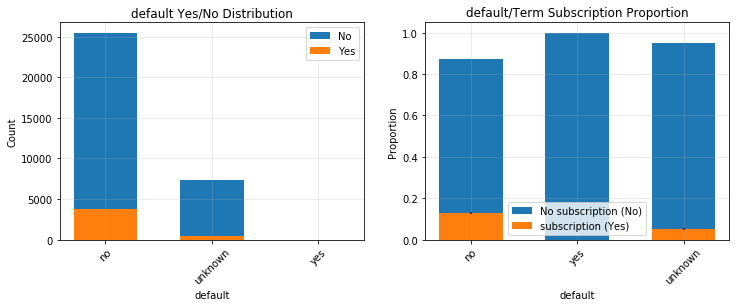

Subscription Confidence Intervals for housing Classes at 95% Confidence:
no confidence interval:    Subscribed (0.1043, 0.1137) Non Subscribed (0.8863, 0.8957)
yes confidence interval:    Subscribed (0.1114, 0.1204) Non Subscribed (0.8796, 0.8886)
unknown confidence interval:    Subscribed (0.0903, 0.1315) Non Subscribed (0.8685, 0.9097)


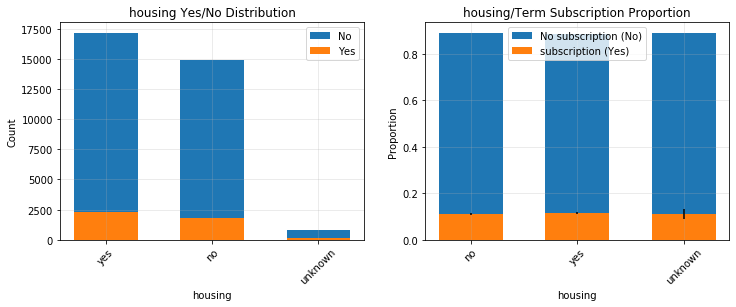

Subscription Confidence Intervals for loan Classes at 95% Confidence:
no confidence interval:    Subscribed (0.1096, 0.1167) Non Subscribed (0.8833, 0.8904)
yes confidence interval:    Subscribed (0.1021, 0.1184) Non Subscribed (0.8816, 0.8979)
unknown confidence interval:    Subscribed (0.0903, 0.1315) Non Subscribed (0.8685, 0.9097)


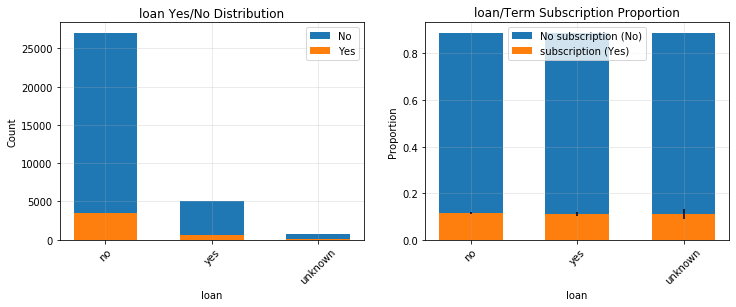

Subscription Confidence Intervals for contact Classes at 95% Confidence:
cellular confidence interval:    Subscribed (0.1427, 0.1518) Non Subscribed (0.8482, 0.8573)
telephone confidence interval:    Subscribed (0.0489, 0.0565) Non Subscribed (0.9435, 0.9511)


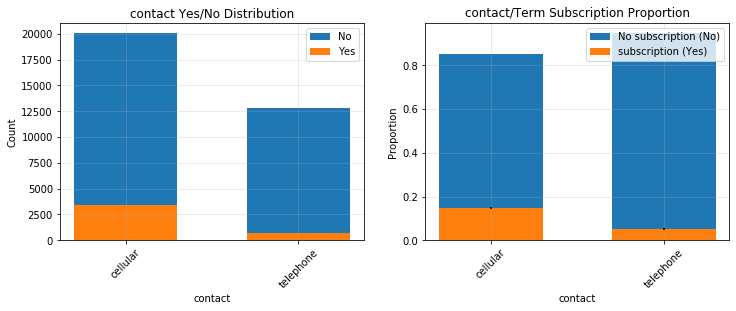

Subscription Confidence Intervals for month Classes at 95% Confidence:
aug confidence interval:    Subscribed (0.0977, 0.1139) Non Subscribed (0.8861, 0.9023)
may confidence interval:    Subscribed (0.0595, 0.0681) Non Subscribed (0.9319, 0.9405)
nov confidence interval:    Subscribed (0.0923, 0.1119) Non Subscribed (0.8881, 0.9077)
dec confidence interval:    Subscribed (0.4018, 0.5552) Non Subscribed (0.4448, 0.5982)
mar confidence interval:    Subscribed (0.46, 0.548) Non Subscribed (0.452, 0.54)
sep confidence interval:    Subscribed (0.4099, 0.495) Non Subscribed (0.505, 0.5901)
jul confidence interval:    Subscribed (0.084, 0.0979) Non Subscribed (0.9021, 0.916)
jun confidence interval:    Subscribed (0.0967, 0.1141) Non Subscribed (0.8859, 0.9033)
oct confidence interval:    Subscribed (0.3941, 0.4706) Non Subscribed (0.5294, 0.6059)
apr confidence interval:    Subscribed (0.1915, 0.2244) Non Subscribed (0.7756, 0.8085)


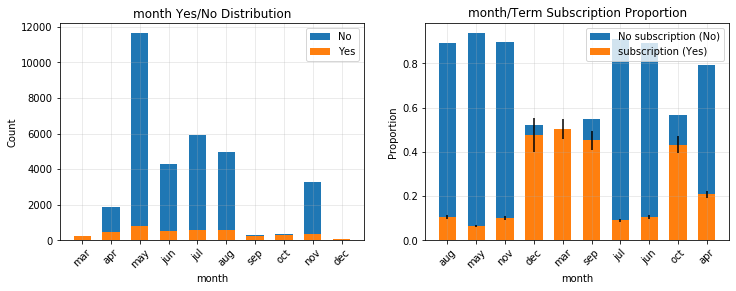

Subscription Confidence Intervals for day_of_week Classes at 95% Confidence:
wed confidence interval:    Subscribed (0.1099, 0.1246) Non Subscribed (0.8754, 0.8901)
thu confidence interval:    Subscribed (0.1123, 0.1267) Non Subscribed (0.8733, 0.8877)
mon confidence interval:    Subscribed (0.0947, 0.1082) Non Subscribed (0.8918, 0.9053)
fri confidence interval:    Subscribed (0.1012, 0.1157) Non Subscribed (0.8843, 0.8988)
tue confidence interval:    Subscribed (0.1094, 0.1241) Non Subscribed (0.8759, 0.8906)


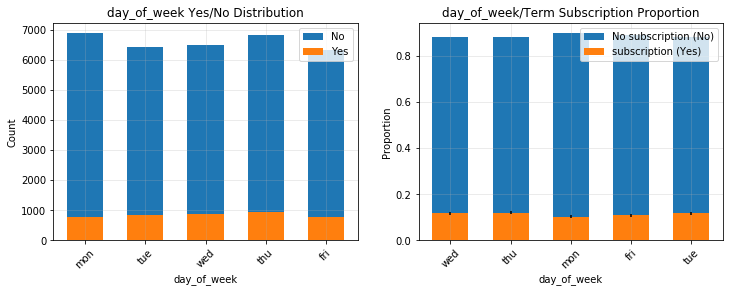

campaign Anderson-Darling test:
Test Statistic: 4253.235040854539    Critical Values: [0.576 0.656 0.787 0.918 1.092]    Significance: [15.  10.   5.   2.5  1. ]


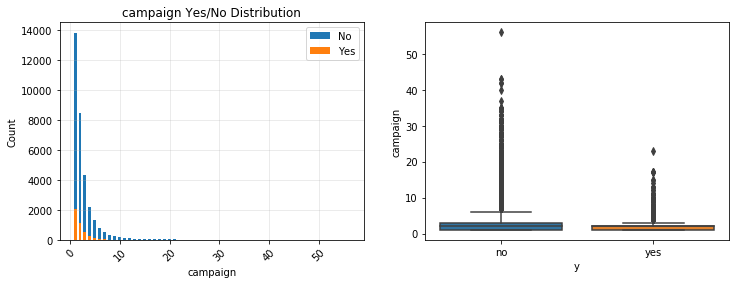

pdays Anderson-Darling test:
Test Statistic: 13658.342915641973    Critical Values: [0.576 0.656 0.787 0.918 1.092]    Significance: [15.  10.   5.   2.5  1. ]


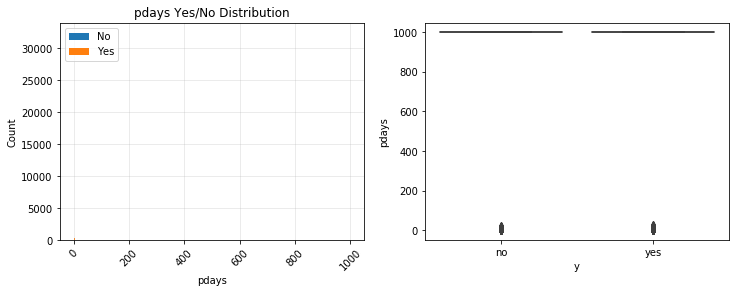

previous Anderson-Darling test:
Test Statistic: 9958.700724727263    Critical Values: [0.576 0.656 0.787 0.918 1.092]    Significance: [15.  10.   5.   2.5  1. ]


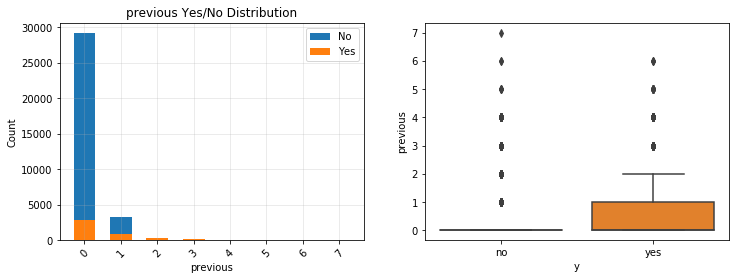

Subscription Confidence Intervals for poutcome Classes at 95% Confidence:
nonexistent confidence interval:    Subscribed (0.0852, 0.0914) Non Subscribed (0.9086, 0.9148)
success confidence interval:    Subscribed (0.6228, 0.6758) Non Subscribed (0.3242, 0.3772)
failure confidence interval:    Subscribed (0.1306, 0.1527) Non Subscribed (0.8473, 0.8694)


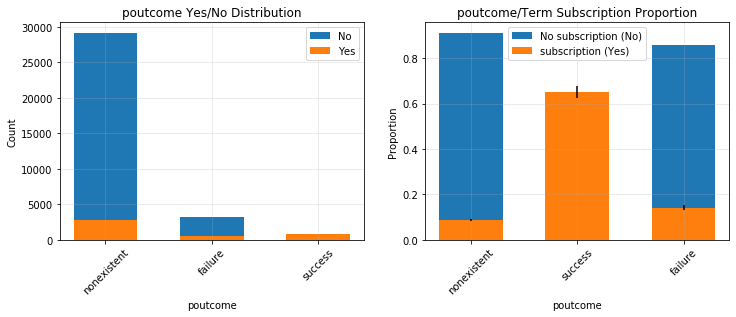

emp.var.rate Anderson-Darling test:
Test Statistic: 3978.9208030759546    Critical Values: [0.576 0.656 0.787 0.918 1.092]    Significance: [15.  10.   5.   2.5  1. ]


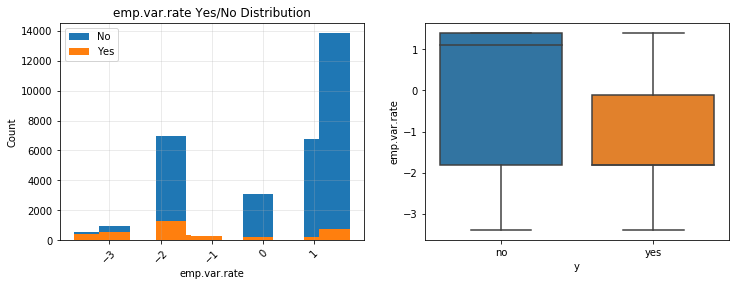

cons.price.idx Anderson-Darling test:
Test Statistic: 1084.7779018228903    Critical Values: [0.576 0.656 0.787 0.918 1.092]    Significance: [15.  10.   5.   2.5  1. ]


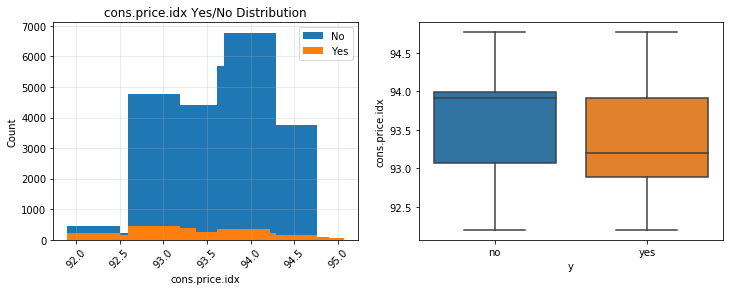

cons.conf.idx Anderson-Darling test:
Test Statistic: 1289.2346273698786    Critical Values: [0.576 0.656 0.787 0.918 1.092]    Significance: [15.  10.   5.   2.5  1. ]


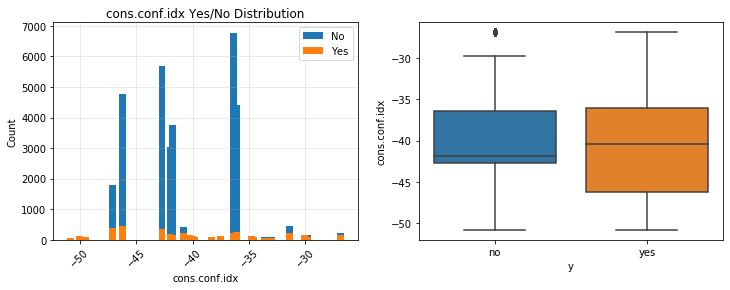

euribor3m Anderson-Darling test:
Test Statistic: 5582.587533833663    Critical Values: [0.576 0.656 0.787 0.918 1.092]    Significance: [15.  10.   5.   2.5  1. ]


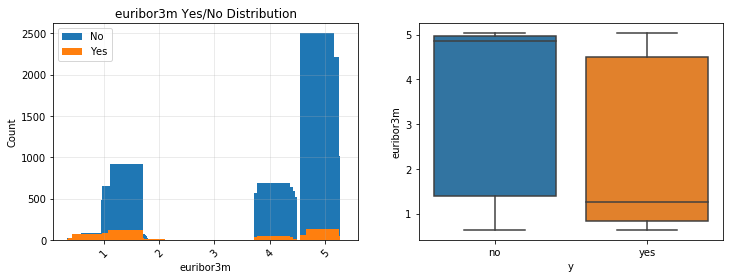

nr.employed Anderson-Darling test:
Test Statistic: 3216.6909058943784    Critical Values: [0.576 0.656 0.787 0.918 1.092]    Significance: [15.  10.   5.   2.5  1. ]


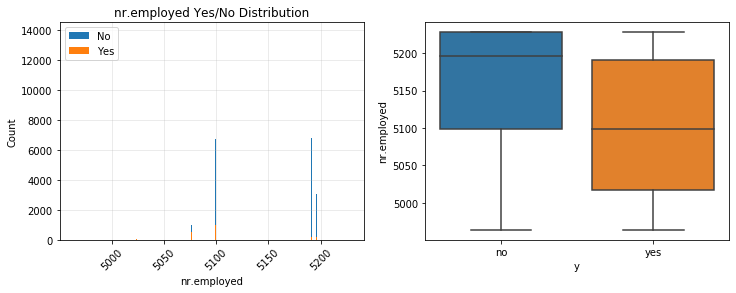

In [37]:
# column yes/no distributions

for col in df.iloc[:, :-1]:
    # anderson-darling test for normality
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        test_stat, crit_vals, sig_lev = anderson(df[col], dist = 'norm')
        print(f'{col} Anderson-Darling test:\nTest Statistic: {test_stat}    Critical Values: {crit_vals}    Significance: {sig_lev}')
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    #if df[col].dtype == 'int64' or df[col].dtype == 'float64': #or col not in ord_cat:
    if col == 'month':
        index = df[col].value_counts().reindex([
                                                'mar','apr','may',
                                                'jun','jul','aug',
                                                'sep','oct','nov','dec'
                                                ]).index.tolist()
    elif col == 'day_of_week':
        index = df[col].value_counts().reindex(['mon','tue','wed','thu','fri']).index.tolist()
    elif col == 'education':
        index = df[col].value_counts().reindex([
                                                'illiterate','basic.4y','basic.6y',
                                                'high.school','basic.9y','professional.course',
                                                'university.degree','unknown'
                                                ]).index.tolist()
    else:
        index = df[col].value_counts().index.tolist()
    yes = []
    no = []
    col_val = []
    for i in index:
        ys = (df[col] == i) & (df['y'] == 'yes')
        ns = (df[col] == i) & (df['y'] == 'no')
        a_yes = len(df[ys])
        a_no = len(df[ns])
        yes.append(a_yes)
        no.append(a_no)
        col_val.append(i)
    col_dict = {'Df Column': col_val, 'Yes': yes, 'No': no}
    col_df = pd.DataFrame(col_dict)

    # stacked bar chart
    idx = col_df['Df Column'].values
    yes_vals = col_df['Yes'].values
    no_vals = col_df['No'].values
    p1 = plt.bar(idx, no_vals, width = 0.60)
    p2 = plt.bar(idx, yes_vals, width = 0.60)

    plt.ylabel('Count')
    plt.xlabel(col)
    plt.xticks(rotation = 45)
    plt.title('{} Yes/No Distribution'.format(col))
    plt.legend((p1[0],p2[0]), ('No', 'Yes'))
    plt.grid(alpha = 0.3)
    #plt.show()
        
# stacked bar for proportions

#for col in df:
    #plt.figure(figsize = (8,4))
    plt.subplot(1,2,2)
    if df[col].dtype == 'O':
        # dataframe for col cats with Y yes/no
        #if col == 'month':
        #    index = df[col].value_counts().reindex([
        #                                            'mar','apr','may',
        #                                            'jun','jul','aug',
        #                                            'sep','oct','nov','dec'
        #                                            ]).index.tolist()
        #elif col == 'day_of_week':
        #    index = df[col].value_counts().reindex(['mon','tue','wed','thu','fri']).index.tolist()
        #elif col == 'education':
        #    index = df[col].value_counts().reindex([
        #                                            'illiterate','basic.4y','basic.6y',
        #                                            'high.school','basic.9y','professional.course',
        #                                            'university.degree','unknown'
        #                                            ]).index.tolist()
        #else:
        #    index = df[col].value_counts().index.tolist()
        yes = []
        no = []
        col_cat = []
        for i in index:
            ys = (df[col] == i) & (df['y'] == 'yes')
            ns = (df[col] == i) & (df['y'] == 'no')
            a_yes = len(df[ys])
            a_no = len(df[ns])
            yes.append(a_yes)
            no.append(a_no)
            col_cat.append(i)
        ex_dict = {col: col_cat, 'Yes': yes, 'No': no}
        ex_df = pd.DataFrame(ex_dict)
        
        cats = ex_df[col].value_counts().index.tolist()
        total_props = []
        no_subs = []
        yes_subs = []
        #for i in range(len(ex_df[col].value_counts().index)):
        # loop to get yes and no proportions for each category class
        for cat in cats:
            tot_prop = int(ex_df[ex_df[col] == cat]['Yes'].values) + int(ex_df[ex_df[col] == cat]['No'].values)
            total_props.append(tot_prop)

            cat_no_sub_prop = int(ex_df[ex_df[col] == cat]['Yes'].values) / tot_prop
            yes_subs.append(cat_no_sub_prop)

            cat_no_nosub_prop = int(ex_df[ex_df[col] == cat]['No'].values) / tot_prop
            no_subs.append(cat_no_nosub_prop)

        # confidence interval at 95%, z-val 1.96
        yes_ci = []
        no_ci = []
        for i in range(len(total_props)):
            y_ci =  1.96 * np.sqrt((yes_subs[i] * (1 - yes_subs[i])) / total_props[i])
            yes_ci.append(y_ci)
            n_ci =  1.96 * np.sqrt((no_subs[i] * (1 - no_subs[i])) / total_props[i])
            no_ci.append(n_ci)

        # print confidence intervals
        print(f'Subscription Confidence Intervals for {col} Classes at 95% Confidence:')
        for c in range(len(cats)):
            print(f'{cats[c]} confidence interval:    Subscribed ({np.round(yes_subs[c]-yes_ci[c],4)}, {np.round(yes_subs[c]+yes_ci[c],4)}) Non Subscribed ({np.round(no_subs[c]-no_ci[c],4)}, {np.round(no_subs[c]+no_ci[c],4)})')
        
        col_dict = {col: cats, 
                     'Yes_proportion': yes_subs,
                     'No_proportion': no_subs}
        col_df = pd.DataFrame(col_dict)

        # stacked bar chart
        idx = col_df[col].values
        yes_vals = col_df['Yes_proportion'].values
        no_vals = col_df['No_proportion'].values
        p1 = plt.bar(idx, no_vals, width = 0.60)
        p2 = plt.bar(idx, yes_vals, width = 0.60, yerr = yes_ci)

        plt.ylabel('Proportion')
        plt.xlabel(col)
        plt.xticks(rotation = 45)
        plt.title('{}/Term Subscription Proportion'.format(col))
        plt.legend((p1[0],p2[0]), ('No subscription (No)', 'subscription (Yes)'))
        plt.grid(alpha = 0.3)
        #plt.show()  
    
    if col in cont_cat:
        sns.boxplot(df.y, df[col])
    plt.show()  

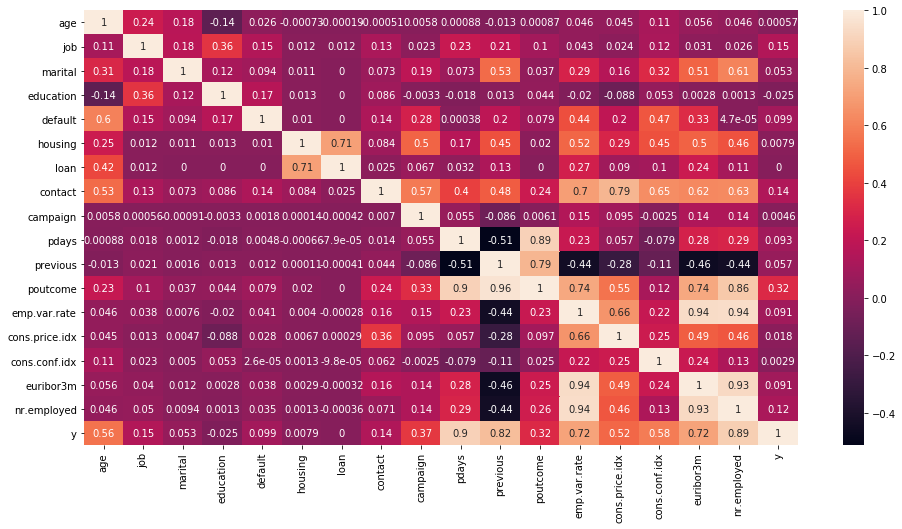

In [77]:
# heatmap for corrlation between variables.. not includng cyclical features
le = LabelEncoder()
heatmap_dict = {}
columns = []
for col1 in df:
    if col1 not in cyclical_cat:
        columns.append(col1)
        corr_vals = []
        for col2 in df:
            if col2 not in cyclical_cat:
                ## continuous - dichotomous cat, logistic regression - f-beta scores
                if col1 in cont_cat and col2 in dich_cat:
                    scores = []
                    for i in range(3):
                        feat_copy = np.array(df[col1].copy()).reshape(-1,1)
                        targ_copy = df[col2].copy()
                        targ_cls = targ_copy.value_counts().index
                        targ_copy.replace(to_replace = [targ_cls[0], targ_cls[1]], value = [1, 0], inplace = True)
                        feat_copy, targ_copy = shuffle(feat_copy, targ_copy)
                        feat_copy_train = feat_copy[:30000]
                        feat_copy_test = feat_copy[30000:]
                        targ_copy_train = targ_copy[:30000]
                        targ_copy_test = targ_copy[30000:]
                        model = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced', max_iter = 250)
                        model.fit(feat_copy_train, targ_copy_train)
                        stat = fbeta_score(targ_copy_test, model.predict(feat_copy_test), beta = 1.0, average = 'micro')
                        scores.append(stat)
                    corr_vals.append(np.mean(scores))
                ## continuous - nominal cat, logistic regression - f-beta scores
                if col1 in cont_cat and col2 in nom_cat:
                    scores = []
                    for i in range(3):
                        feat_copy = np.array(df[col1].copy()).reshape(-1,1)
                        targ_copy = df[col2].copy()
                        feat_copy, targ_copy = shuffle(feat_copy, targ_copy)
                        targ_copy = le.fit_transform(targ_copy)
                        feat_copy_train = feat_copy[:30000]
                        feat_copy_test = feat_copy[30000:]
                        targ_copy_train = targ_copy[:30000]
                        targ_copy_test = targ_copy[30000:]
                        model = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced', 
                                                   multi_class = 'multinomial', max_iter = 200)
                        model.fit(feat_copy_train, targ_copy_train)
                        stat = fbeta_score(targ_copy_test, model.predict(feat_copy_test), beta = 1.0, average = 'micro')
                        scores.append(stat)
                        
                    corr_vals.append(np.mean(scores))
                # continuous - continuous, pearsons or spearman rank coef
                if col1 in cont_cat and col2 in cont_cat:
                    stat = spearmanr(df[col1], df[col2])[0]
                    corr_vals.append(stat)
                # continuous - ordinal, spearman rank
                if col1 in cont_cat and col2 in ord_cat:
                    count = 0
                    edu_rank = df.education.copy()
                    for cat in df.education.value_counts().reindex([
                                                                    'unknown','illiterate','basic.4y','basic.6y',
                                                                    'high.school','professional.course','basic.9y',
                                                                    'university.degree'
                                                                    ]).index.tolist():
                        bool_array = edu_rank == cat
                        edu_rank[bool_array] = count
                        count += 1
                    stat = spearmanr(df[col1], edu_rank)[0]
                    corr_vals.append(stat)

                # nominal - dichotomous, cramers v
                if col1 in nom_cat and col2 in dich_cat:
                    c_table = pd.crosstab(df[col1], df[col2]).values
                    stat = cramers_corrected_stat(c_table)
                    corr_vals.append(stat)
                # nominal - nominal, cramers v
                if col1 in nom_cat and col2 in nom_cat:
                    c_table = pd.crosstab(df[col1], df[col2]).values
                    stat = cramers_corrected_stat(c_table)
                    corr_vals.append(stat)
                # nominal - continuous, linear regression - r2 scores
                if col1 in nom_cat and col2 in cont_cat:
                    scores = []
                    for i in range(3):
                        feat_copy = df[col1].copy()
                        feat_copy = pd.get_dummies(feat_copy)
                        targ_copy = df[col2].copy()
                        feat_copy, targ_copy = shuffle(feat_copy, targ_copy)
                        feat_train = feat_copy[0:30000]
                        feat_test = feat_copy[30000:]
                        targ_train = targ_copy[0:30000]
                        targ_test = targ_copy[30000:]
                        model = LinearRegression()
                        model.fit(feat_train, targ_train)
                        r2 = r2_score(targ_test, model.predict(feat_test))
                        scores.append(r2)
                    corr_vals.append(np.mean(scores))
                
                ## nominal - ordinal, cramers v
                if col1 in nom_cat and col2 in ord_cat:
                    c_table = pd.crosstab(df[col1], df[col2]).values
                    stat = cramers_corrected_stat(c_table)
                    corr_vals.append(stat)

                # dichotomous - dichotomous, phi
                if col1 in dich_cat and col2 in dich_cat:
                    c_table = pd.crosstab(df[col1], df[col2]).values 
                    stat = phi(c_table)
                    corr_vals.append(stat)
                # dichotomous - nominal, cramers v
                if col1 in dich_cat and col2 in nom_cat:
                    c_table = pd.crosstab(df[col1], df[col2]).values
                    stat = cramers_corrected_stat(c_table)
                    corr_vals.append(stat)
                ## dichotomous - continuous, linear regression - r2 score
                if col1 in dich_cat and col2 in cont_cat:
                    scores = []
                    for i in range(3):
                        feat_copy = df[col1].copy()
                        feat_cls = feat_copy.value_counts().index
                        feat_copy.replace(to_replace = [feat_cls[0], feat_cls[1]], value = [1, 0], inplace = True)
                        targ_copy = df[col2].copy()
                        feat_copy, targ_copy = shuffle(feat_copy, targ_copy)
                        feat_copy = np.array(feat_copy).reshape(-1,1)
                        feat_copy_train = feat_copy[0:30000]
                        feat_copy_test = feat_copy[30000:]
                        targ_copy_train = targ_copy[0:30000]
                        targ_copy_test = targ_copy[30000:]
                        model = LinearRegression()
                        model.fit(feat_copy_train, targ_copy_train)
                        stat = r2_score(targ_copy_test, model.predict(feat_copy_test))
                        scores.append(stat)
                    corr_vals.append(np.mean(scores))
                ## dichotomous - ordinal, kendall tau
                if col1 in dich_cat and col2 in ord_cat:
                    # encode dichotomous feature
                    dich_copy = df[col1].copy()
                    feat_cls = dich_copy.value_counts().index
                    dich_copy.replace(to_replace = [feat_cls[0], feat_cls[1]], value = [1, 0], inplace = True)

                    # encode ordinal feature
                    count = 0
                    edu_rank = df.education.copy()
                    for cat in df.education.value_counts().reindex([
                                                                    'unknown','illiterate','basic.4y','basic.6y',
                                                                    'high.school','professional.course','basic.9y',
                                                                    'university.degree'
                                                                    ]).index.tolist():
                        bool_array = edu_rank == cat
                        edu_rank[bool_array] = count
                        count += 1

                    stat = kendalltau(dich_copy, edu_rank)[0]
                    corr_vals.append(stat)

                ## ordinal - dichotomous, kendall tau
                if col1 in ord_cat and col2 in dich_cat:
                    # encode ordinal feature
                    count = 0
                    edu_rank = df.education.copy()
                    for cat in df.education.value_counts().reindex([
                                                                    'unknown','illiterate','basic.4y','basic.6y',
                                                                    'high.school','professional.course','basic.9y',
                                                                    'university.degree'
                                                                    ]).index.tolist():
                        bool_array = edu_rank == cat
                        edu_rank[bool_array] = count
                        count += 1

                    # encode dichotomous feature
                    dich_copy = df[col2].copy()
                    feat_cls = dich_copy.value_counts().index
                    dich_copy.replace(to_replace = [feat_cls[0], feat_cls[1]], value = [1, 0], inplace = True)

                    stat = kendalltau(edu_rank, dich_copy)[0]
                    corr_vals.append(stat)
                ## ordinal - nominal, cramers v
                if col1 in ord_cat and col2 in nom_cat:
                    c_table = pd.crosstab(df[col1], df[col2]).values
                    stat = cramers_corrected_stat(c_table)
                    corr_vals.append(stat)
                # ordinal - continuous, spearman rank
                if col1 in ord_cat and col2 in cont_cat:
                    count = 0
                    edu_rank = df.education.copy()
                    for cat in df.education.value_counts().reindex([
                                                                    'unknown','illiterate','basic.4y','basic.6y',
                                                                    'high.school','professional.course','basic.9y',
                                                                    'university.degree'
                                                                    ]).index.tolist():
                        bool_array = edu_rank == cat
                        edu_rank[bool_array] = count
                        count += 1
                    stat = spearmanr(edu_rank, df[col2])[0]
                    corr_vals.append(stat)
                # ordinal - ordinal, kendall tau
                if col1 in ord_cat and col2 in ord_cat:
                    stat = kendalltau(df[col1], df[col2])[0]
                    corr_vals.append(stat)

            heatmap_dict[col1] = corr_vals
        
corr_grid = pd.DataFrame(heatmap_dict, index = columns)
#corr_grid
plt.figure(figsize = (16,8))
sns.heatmap(corr_grid, annot = True)
plt.show()

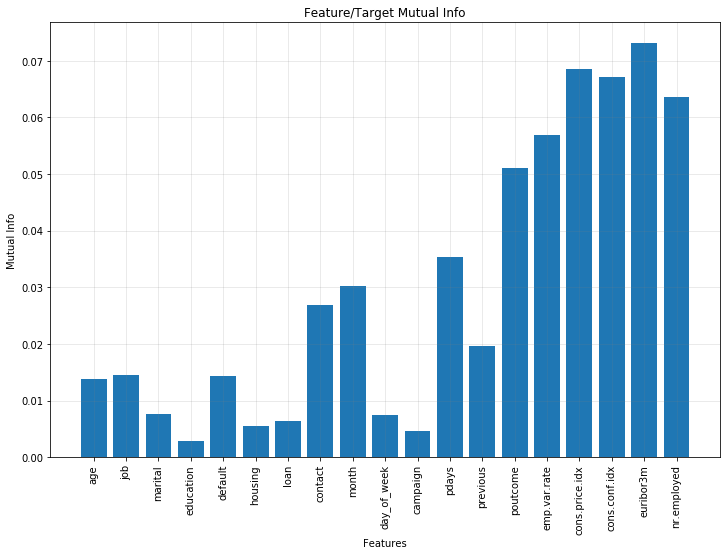

In [78]:
## mutual info plot between features and target
f_col = []
m_info = []

mi_feats = df.iloc[:, :-1].copy()

cat_feats = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

for col in mi_feats.columns.tolist():
    if col in cat_feats:
        oh_df = pd.get_dummies(mi_feats[col])
        oh_m_info = []
        for oh_col in oh_df:
            f = oh_df[oh_col]
            f = np.array(f).reshape(-1,1)
            mi = mutual_info_classif(f, df.y)
            oh_m_info.append(mi)
        f_col.append(col)
        m_info.append(np.sum(oh_m_info))
    else:
        f = mi_feats[col]
        f = np.array(f).reshape(-1,1)
        mi = mutual_info_classif(f, df.y)
        f_col.append(col)
        m_info.append(mi)
plt.figure(figsize = (12,8))
plt.bar(f_col, m_info)
plt.grid(color = 'gray', linestyle = '-', alpha = .2)
plt.title('Feature/Target Mutual Info')
plt.xlabel('Features')
plt.xticks(rotation = 90)
plt.ylabel('Mutual Info')
plt.show()

We can remove job, marital, education, default, housing and loan features as they have minimal to no association or provide much information gain with our y target.

Contact also has minimal association with the target variable but it provides more in the way of information gain so we can keep this feature for now.

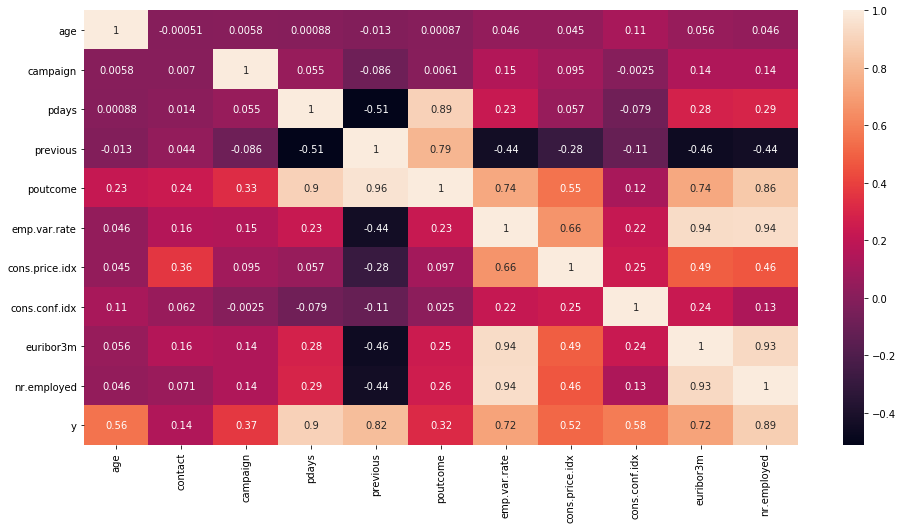

In [79]:
# heatmap of top correlated features
top_corr = ['age', 'contact', 'campaign', 'pdays', 
          'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 
          'cons.conf.idx', 'euribor3m', 'nr.employed']
plt.figure(figsize = (16,8))
sns.heatmap(corr_grid[top_corr].iloc[[0,8,9,10,11,12,13,14,15,16,17],:], annot = True)
plt.show()

There is high multicollinearity within the features that are highly correlated with y, we can see the extent of this multicollinearity by checking the variance inflation factor of the features.

In [38]:
# variance inflation factor for multicollinearity
vif_copy = df[top_corr].copy()
le = LabelEncoder()
vif_copy['poutcome'] = le.fit_transform(vif_copy['poutcome'])
vif_copy['contact'] = le.fit_transform(vif_copy['contact'])

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(vif_copy.values, i) for i in range(vif_copy.shape[1])]
vif["features"] = vif_copy.columns
vif.sort_values(by = 'VIF Factor', ascending = False)

,VIF Factor,features
10,138322.291453,nr.employed
7,133423.953849,cons.price.idx
3,956.906078,pdays
9,324.822832,euribor3m
8,256.671904,cons.conf.idx
5,207.938112,poutcome
6,29.782343,emp.var.rate
4,21.555729,previous
0,18.799803,age
1,5.378470,contact


Due to the majority of features being colinear performing PCA to reduce the features might be one option and another using tree based algorithms.

### - Baseline -

In [79]:
# baseline score using f-beta that minimizes false negatives (maximizing recall) ##### fbeta weighted 1.5
feats, targ = baseline_preprocess(df)
model = DummyClassifier(strategy = 'constant', constant = 1)
scores = evaluate_model(feats, targ, model)
print(f'Baseline F-beta Score: {np.round(np.mean(scores),3)}, Std: {np.std(scores)}')

Baseline F-beta Score: 0.292, Std: 0.0002689116126952076


In [32]:
# base rate model profit
_ , hold_target = load_data(hold_data)
pred_ones = np.ones(shape = (len(hold_target),))
cm = confusion_matrix(hold_target, pred_ones)
cost_ben = np.array([[0,-30],[0,500-30]])
exp_val = expected_value(cm,cost_ben)
print(f'Base rate expected profit: {exp_val}')

Base rate expected profit: 25.0


In [106]:
## simple model one of the best features for comparison
feats, targ = load_data(df)
test_feats, test_targ = load_data(hold_data)

# use one best feature for training
best_feat = feats[['nr.employed']]
# use one best feature for testing
test_best_feat = test_feats[['nr.employed']]

cv_model = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')
test_val_model = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')
# cv
scores = evaluate_model(best_feat, targ, cv_model)
print(f'Avg Fbeta: {np.mean(scores)}        Std: {np.std(scores)}\n')

# train, val test for confusion matrix
test_val_model.fit(best_feat, targ)
pred = test_val_model.predict(test_best_feat)
cm = confusion_matrix(test_targ, pred)
print(f'Confusion Matrix:\n{cm}')


Avg Fbeta: 0.446351498203584        Std: 0.011774778961796286

Confusion Matrix:
[[2657  998]
 [ 123  341]]


We have an fbeta baseline score of 0.292 and a simple model fbeta score of 0.446, models that improve on this score have skill and those that dont have no skill.

We have a base rate model profit of £25, if we target everyone on average we would expect to make £25 per client.

### - Feature Engineering -

In [38]:
features = df.copy()
#target = df.y.copy()

In [39]:
# remove unassociated features
# train data
features.drop(labels = ['job','marital','education','default','housing','loan'], axis = 'columns', inplace = True)
# hold data
hold_data.drop(labels = ['job','marital','education','default','housing','loan'], axis = 'columns', inplace = True)

In [40]:
# season feature
features.insert(2, 'season', 0, True)
hold_data.insert(2, 'season', 0, True)

#spring
# train data
mar_index = features[features['month'] == 'mar'].index
features.loc[mar_index, 'season'] = 'spring'
apr_index = features[features['month'] == 'apr'].index
features.loc[apr_index, 'season'] = 'spring'
may_index = features[features['month'] == 'may'].index
features.loc[may_index, 'season'] = 'spring'
# hold data
h_mar_index = hold_data[hold_data['month'] == 'mar'].index
hold_data.loc[h_mar_index, 'season'] = 'spring'
h_apr_index = hold_data[hold_data['month'] == 'apr'].index
hold_data.loc[h_apr_index, 'season'] = 'spring'
h_may_index = hold_data[hold_data['month'] == 'may'].index
hold_data.loc[h_may_index, 'season'] = 'spring'

#summer
# train data
jun_index = features[features['month'] == 'jun'].index
features.loc[jun_index, 'season'] = 'summer'
jul_index = features[features['month'] == 'jul'].index
features.loc[jul_index, 'season'] = 'summer'
aug_index = features[features['month'] == 'aug'].index
features.loc[aug_index, 'season'] = 'summer'
# hold data
h_jun_index = hold_data[hold_data['month'] == 'jun'].index
hold_data.loc[h_jun_index, 'season'] = 'summer'
h_jul_index = hold_data[hold_data['month'] == 'jul'].index
hold_data.loc[h_jul_index, 'season'] = 'summer'
h_aug_index = hold_data[hold_data['month'] == 'aug'].index
hold_data.loc[h_aug_index, 'season'] = 'summer'

#autumn
# train data
sep_index = features[features['month'] == 'sep'].index
features.loc[sep_index, 'season'] = 'autumn'
oct_index = features[features['month'] == 'oct'].index
features.loc[oct_index, 'season'] = 'autumn'
nov_index = features[features['month'] == 'nov'].index
features.loc[nov_index, 'season'] = 'autumn'
# hold data
h_sep_index = hold_data[hold_data['month'] == 'sep'].index
hold_data.loc[h_sep_index, 'season'] = 'autumn'
h_oct_index = hold_data[hold_data['month'] == 'oct'].index
hold_data.loc[h_oct_index, 'season'] = 'autumn'
h_nov_index = hold_data[hold_data['month'] == 'nov'].index
hold_data.loc[h_nov_index, 'season'] = 'autumn'

#winter
# train data
dec_index = features[features['month'] == 'dec'].index
features.loc[dec_index, 'season'] = 'winter'
# hold data
h_dec_index = hold_data[hold_data['month'] == 'dec'].index
hold_data.loc[h_dec_index, 'season'] = 'winter'

In [41]:
# yearly quarters
features.insert(3, 'yearly_quarter', 0, True)
hold_data.insert(3, 'yearly_quarter', 0, True)

# Q1
# train data
mar_index = features[features['month'] == 'mar'].index
features.loc[mar_index, 'yearly_quarter'] = 'Q1'
# hold data
h_mar_index = hold_data[hold_data['month'] == 'mar'].index
hold_data.loc[h_mar_index, 'yearly_quarter'] = 'Q1'

# Q2
# train data
apr_index = features[features['month'] == 'apr'].index
features.loc[apr_index, 'yearly_quarter'] = 'Q2'
may_index = features[features['month'] == 'may'].index
features.loc[may_index, 'yearly_quarter'] = 'Q2'
jun_index = features[features['month'] == 'jun'].index
features.loc[jun_index, 'yearly_quarter'] = 'Q2'
# hold data
h_apr_index = hold_data[hold_data['month'] == 'apr'].index
hold_data.loc[h_apr_index, 'yearly_quarter'] = 'Q2'
h_may_index = hold_data[hold_data['month'] == 'may'].index
hold_data.loc[h_may_index, 'yearly_quarter'] = 'Q2'
h_jun_index = hold_data[hold_data['month'] == 'jun'].index
hold_data.loc[h_jun_index, 'yearly_quarter'] = 'Q2'

# Q3
# train data
jul_index = features[features['month'] == 'jul'].index
features.loc[jul_index, 'yearly_quarter'] = 'Q3'
aug_index = features[features['month'] == 'aug'].index
features.loc[aug_index, 'yearly_quarter'] = 'Q3'
sep_index = features[features['month'] == 'sep'].index
features.loc[sep_index, 'yearly_quarter'] = 'Q3'
# hold data
h_jul_index = hold_data[hold_data['month'] == 'jul'].index
hold_data.loc[h_jul_index, 'yearly_quarter'] = 'Q3'
h_aug_index = hold_data[hold_data['month'] == 'aug'].index
hold_data.loc[h_aug_index, 'yearly_quarter'] = 'Q3'
h_sep_index = hold_data[hold_data['month'] == 'sep'].index
hold_data.loc[h_sep_index, 'yearly_quarter'] = 'Q3'

# Q4
# train data
oct_index = features[features['month'] == 'oct'].index
features.loc[oct_index, 'yearly_quarter'] = 'Q4'
nov_index = features[features['month'] == 'nov'].index
features.loc[nov_index, 'yearly_quarter'] = 'Q4'
dec_index = features[features['month'] == 'dec'].index
features.loc[dec_index, 'yearly_quarter'] = 'Q4'
# hold data
h_oct_index = hold_data[hold_data['month'] == 'oct'].index
hold_data.loc[h_oct_index, 'yearly_quarter'] = 'Q4'
h_nov_index = hold_data[hold_data['month'] == 'nov'].index
hold_data.loc[h_nov_index, 'yearly_quarter'] = 'Q4'
h_dec_index = hold_data[hold_data['month'] == 'dec'].index
hold_data.loc[h_dec_index, 'yearly_quarter'] = 'Q4'

In [42]:
# contacted in previous campaign
features.insert(7, 'pdays_contact', 0 ,True)
hold_data.insert(7, 'pdays_contact', 0 ,True)

# contacted before
# train data
con = features['pdays'] < 999
features.loc[con, 'pdays_contact'] = 1
# hold data
h_con = hold_data['pdays'] < 999
hold_data.loc[h_con, 'pdays_contact'] = 1

In [43]:
# cyclical features
# month
# train data
count = 3
month_idx = features.month.copy()
for cat in features.month.value_counts().reindex(['mar','apr','may',
                                            'jun','jul','aug',
                                            'sep','oct','nov','dec']).index.tolist():
    bool_array = month_idx == cat
    month_idx[bool_array] = count
    count += 1

month_idx = month_idx.astype('int64')
features['month_sin'] = np.sin(2*np.pi*month_idx/12)
features['month_cos'] = np.cos(2*np.pi*month_idx/12)
# hold data
count = 3
h_month_idx = hold_data.month.copy()
for cat in hold_data.month.value_counts().reindex(['mar','apr','may',
                                            'jun','jul','aug',
                                            'sep','oct','nov','dec']).index.tolist():
    bool_array = h_month_idx == cat
    h_month_idx[bool_array] = count
    count += 1

h_month_idx = h_month_idx.astype('int64')
hold_data['month_sin'] = np.sin(2*np.pi*h_month_idx/12)
hold_data['month_cos'] = np.cos(2*np.pi*h_month_idx/12)

# day_of_week
# train data
count = 1
day_idx = features.day_of_week.copy()
for cat in features.day_of_week.value_counts().reindex(['mon','tue','wed','thu','fri']).index.tolist():
    bool_array = day_idx == cat
    day_idx[bool_array] = count
    count += 1

day_idx = day_idx.astype('int64')
features['day_sin'] = np.sin(2*np.pi*day_idx/7)
features['day_cos'] = np.cos(2*np.pi*day_idx/7)
# hold data
count = 1
h_day_idx = hold_data.day_of_week.copy()
for cat in hold_data.day_of_week.value_counts().reindex(['mon','tue','wed','thu','fri']).index.tolist():
    bool_array = h_day_idx == cat
    h_day_idx[bool_array] = count
    count += 1

h_day_idx = h_day_idx.astype('int64')
hold_data['day_sin'] = np.sin(2*np.pi*h_day_idx/7)
hold_data['day_cos'] = np.cos(2*np.pi*h_day_idx/7)

# season
# train data
count = 1
season_idx = features.season.copy()
for cat in features.season.value_counts().reindex(['spring','summer','autumn','winter']).index.tolist():
    bool_array = season_idx == cat
    season_idx[bool_array] = count
    count += 1

season_idx = season_idx.astype('int64')
features['season_sin'] = np.sin(2*np.pi*season_idx/4)
features['season_cos'] = np.cos(2*np.pi*season_idx/4)
# hold data
count = 1
h_season_idx = hold_data.season.copy()
for cat in hold_data.season.value_counts().reindex(['spring','summer','autumn','winter']).index.tolist():
    bool_array = h_season_idx == cat
    h_season_idx[bool_array] = count
    count += 1

h_season_idx = h_season_idx.astype('int64')
hold_data['season_sin'] = np.sin(2*np.pi*h_season_idx/4)
hold_data['season_cos'] = np.cos(2*np.pi*h_season_idx/4)

# yearly quarter
# train data
count = 1
q_idx = features.yearly_quarter.copy()
for cat in features.yearly_quarter.value_counts().reindex(['Q1','Q2','Q3','Q4']).index.tolist():
    bool_array = q_idx == cat
    q_idx[bool_array] = count
    count += 1

q_idx = q_idx.astype('int64')
features['quarterly_sin'] = np.sin(2*np.pi*q_idx/4)
features['quarterly_cos'] = np.cos(2*np.pi*q_idx/4)
# hold data
count = 1
h_q_idx = hold_data.yearly_quarter.copy()
for cat in hold_data.yearly_quarter.value_counts().reindex(['Q1','Q2','Q3','Q4']).index.tolist():
    bool_array = h_q_idx == cat
    h_q_idx[bool_array] = count
    count += 1

h_q_idx = h_q_idx.astype('int64')
hold_data['quarterly_sin'] = np.sin(2*np.pi*h_q_idx/4)
hold_data['quarterly_cos'] = np.cos(2*np.pi*h_q_idx/4)

# remove original month, day_of_week & season features
features.drop(labels = ['month', 'day_of_week', 'season', 'yearly_quarter'], axis = 'columns', inplace = True)
hold_data.drop(labels = ['month', 'day_of_week', 'season', 'yearly_quarter'], axis = 'columns', inplace = True)

In [44]:
# was an outcome from previous outcome
features.insert(6, 'was_outcome', 0, True)
hold_data.insert(6, 'was_outcome', 0, True)

# train data
bool_array = features['poutcome'] == 'failure'
features.loc[bool_array, 'was_outcome'] = 1

bool_array = features['poutcome'] == 'success'
features.loc[bool_array, 'was_outcome'] = 1

# hold data
h_bool_array = hold_data['poutcome'] == 'failure'
hold_data.loc[h_bool_array, 'was_outcome'] = 1

h_bool_array = hold_data['poutcome'] == 'success'
hold_data.loc[h_bool_array, 'was_outcome'] = 1

In [45]:
# was contacted previously before this campaign
features.insert(6, 'prev_contacted', 0, True)
hold_data.insert(6, 'prev_contacted', 0, True)
# train data
bool_array = features['previous'] != 0
features.loc[bool_array, 'prev_contacted'] = 1
# hold data
h_bool_array = hold_data['previous'] != 0
hold_data.loc[h_bool_array, 'prev_contacted'] = 1

In [46]:
# bin ages
features.insert(2, 'age_bin', 0, True)
hold_data.insert(2, 'age_bin', 0, True)
# train data
features['age_bin'] = np.floor_divide(features['age'], 10)
# hold data
hold_data['age_bin'] = np.floor_divide(hold_data['age'], 10)

In [47]:
# log of campaign
features.insert(4, 'log_campaign', 0, True)
hold_data.insert(4, 'log_campaign', 0, True)
# train data
features['log_campaign'] = np.log10(features['campaign'] + 1)
# hold data
hold_data['log_campaign'] = np.log10(hold_data['campaign'] + 1)

In [48]:
# log of pdays
features.insert(6, 'log_pdays', 0, True)
hold_data.insert(6, 'log_pdays', 0, True)
# train data
features['log_pdays'] = np.log10(features['pdays'] +1)
# hold data
hold_data['log_pdays'] = np.log10(hold_data['pdays'] +1)

In [49]:
# campaign outliers above upper bound 6.0
features.insert(5, 'campaign_outliers', 0, True)
hold_data.insert(5, 'campaign_outliers', 0, True)
# train data
bool_array = features['campaign'] > 6.0
features.loc[bool_array, 'campaign_outliers'] = 1
# hold data
h_bool_array = hold_data['campaign'] > 6.0
hold_data.loc[h_bool_array, 'campaign_outliers'] = 1

In [50]:
# put y back at end
features = features[
    [
        'age',
         'age_bin',
         'contact',
         'campaign',
         'log_campaign', 
         'campaign_outliers',
         'pdays',
         'log_pdays',
         'pdays_contact',
         'previous',
         'prev_contacted',
         'poutcome',
         'was_outcome',
         'emp.var.rate',
         'cons.price.idx',
         'cons.conf.idx',
         'euribor3m',
         'nr.employed',
         'month_sin',
         'month_cos',
         'day_sin',
         'day_cos',
         'season_sin',
         'season_cos',
         'quarterly_sin',
         'quarterly_cos',
         'y'
    ]
]
# hold data
hold_data = hold_data[
    [
        'age',
         'age_bin',
         'contact',
         'campaign',
         'log_campaign', 
         'campaign_outliers',
         'pdays',
         'log_pdays',
         'pdays_contact',
         'previous',
         'prev_contacted',
         'poutcome',
         'was_outcome',
         'emp.var.rate',
         'cons.price.idx',
         'cons.conf.idx',
         'euribor3m',
         'nr.employed',
         'month_sin',
         'month_cos',
         'day_sin',
         'day_cos',
         'season_sin',
         'season_cos',
         'quarterly_sin',
         'quarterly_cos',
         'y'
    ]
]

In [108]:
# variable type
cont_cat = ['age', 'age_bin','campaign', 'log_campaign', 'pdays', 'log_pdays',
            'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
dich_cat = ['contact', 'campaign_outliers', 'pdays_contact', 'prev_contacted', 'was_outcome']
nom_cat = ['poutcome']

# combine cyclical features into dataframes for analysis
day_df = pd.DataFrame(data = {'day_sin':features.day_sin, 'day_cos':features.day_cos})
month_df = pd.DataFrame(data = {'month_sin':features.month_sin, 'month_cos':features.month_cos})
season_df = pd.DataFrame(data = {'season_sin':features.season_sin, 'season_cos':features.season_cos})
quarter_df = pd.DataFrame(data = {'quarterly_sin':features.quarterly_sin, 'quarterly_cos': features.quarterly_cos})

cyclical_cat = [day_df, month_df, season_df, quarter_df]

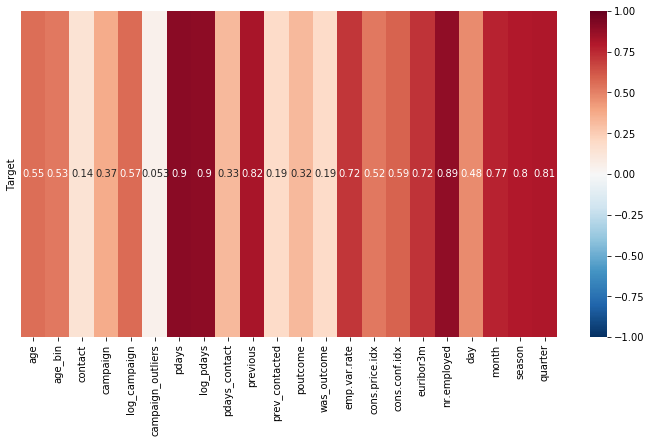

In [109]:
# feature-target correlation/association
removed = ['month_sin','month_cos','day_sin','day_cos','season_sin','season_cos','quarterly_sin','quarterly_cos','y']
heatmap_dict = {}
columns = []
for col in features:
    if col not in removed:
        columns.append(col)
        corr_vals = []
        if col in cont_cat: # logistic regression - fbeta score
            scores = []
            for i in range(3):
                feat_copy = np.array(features[col].copy()).reshape(-1,1)
                targ_copy = features.y.copy()
                #targ_cls = targ_copy.value_counts().index
                #targ_copy.replace(to_replace = [targ_cls[0], targ_cls[1]], value = [1, 0], inplace = True)
                feat_copy, targ_copy = shuffle(feat_copy, targ_copy)
                feat_copy_train = feat_copy[:30000]
                feat_copy_test = feat_copy[30000:]
                targ_copy_train = targ_copy[:30000]
                targ_copy_test = targ_copy[30000:]
                model = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced', max_iter = 250)
                model.fit(feat_copy_train, targ_copy_train)
                stat = fbeta_score(targ_copy_test, model.predict(feat_copy_test), beta = 2.0, average = 'micro')
                scores.append(stat)
            corr_vals.append(np.mean(scores))
        if col in dich_cat: # phi
            c_table = pd.crosstab(features[col], features.y).values 
            stat = phi(c_table)
            corr_vals.append(stat)
        if col in nom_cat: # cramers v
            c_table = pd.crosstab(features[col], features.y).values
            stat = cramers_corrected_stat(c_table)
            corr_vals.append(stat)
    
    heatmap_dict[col] = corr_vals
    
for d in cyclical_cat:
    if 'day_sin' in d:
        col_name = 'day'
        columns.append(col_name)
    if 'month_sin' in d:
        col_name = 'month'
        columns.append(col_name)
    if 'season_sin' in d:
        col_name = 'season'
        columns.append(col_name)
    if 'quarterly_sin' in d:
        col_name = 'quarter'
        columns.append(col_name)
    corr_vals = []
    scores = []
    for i in range(3):
        feat_copy = d.copy()
        targ_copy = features.y.copy()
        targ_cls = targ_copy.value_counts().index
        targ_copy.replace(to_replace = [targ_cls[0], targ_cls[1]], value = [0, 1], inplace = True)
        feat_copy, targ_copy = shuffle(feat_copy, targ_copy)
        feat_copy_train = feat_copy[:30000]
        feat_copy_test = feat_copy[30000:]
        targ_copy_train = targ_copy[:30000]
        targ_copy_test = targ_copy[30000:]
        model = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced', max_iter = 250)
        model.fit(feat_copy_train, targ_copy_train)
        stat = fbeta_score(targ_copy_test, model.predict(feat_copy_test), beta = 2.0, average = 'micro')
        scores.append(stat)
    corr_vals.append(np.mean(scores))
    
    heatmap_dict[col_name] = corr_vals
    

corr_grid = pd.DataFrame(heatmap_dict)
plt.figure(figsize = (12,6))
sns.heatmap(corr_grid.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,27,28,29,30]], annot = True, vmin = -1, vmax = 1, 
            cmap = 'RdBu_r', yticklabels = False)
plt.ylabel('Target')
plt.show()

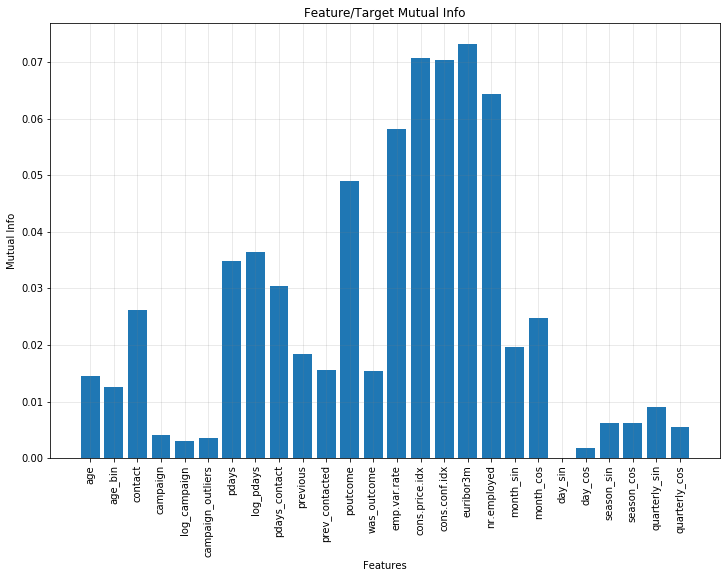

In [110]:
## mutual info plot between features and target
f_col = []
m_info = []

mi_feats = features.iloc[:, :-1].copy()
cat_feats = ['poutcome', 'contact']

for col in mi_feats.columns.tolist():
    if col in cat_feats:
        oh_df = pd.get_dummies(mi_feats[col])
        oh_m_info = []
        for oh_col in oh_df:
            f = oh_df[oh_col]
            f = np.array(f).reshape(-1,1)
            mi = mutual_info_classif(f, features.y)
            oh_m_info.append(mi)
        f_col.append(col)
        m_info.append(np.sum(oh_m_info))
    else:
        f = mi_feats[col]
        f = np.array(f).reshape(-1,1)
        mi = mutual_info_classif(f, features.y)
        f_col.append(col)
        m_info.append(mi)
plt.figure(figsize = (12,8))
plt.bar(f_col, m_info)
plt.grid(color = 'gray', linestyle = '-', alpha = .2)
plt.title('Feature/Target Mutual Info')
plt.xlabel('Features')
plt.xticks(rotation = 90)
plt.ylabel('Mutual Info')
plt.show()

In [111]:
# one hot encode and create PCA transformed features dataframe
pca_feats = features.copy()
pca_feats = pd.get_dummies(data = pca_feats, drop_first = True)
sc = StandardScaler()
pca_feats = sc.fit_transform(pca_feats)

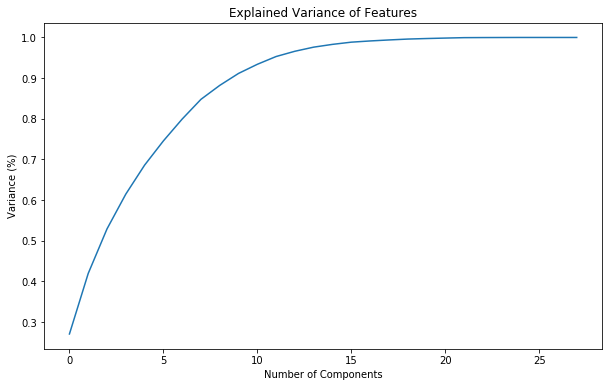

In [112]:
#Fitting the PCA algorithm with our Data to find best number of principal components
pca = PCA().fit(pca_feats)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize = (10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance of Features')
plt.show()

From the graph we can see that selecting 12 components we can preserve approximately 98% of the total variance of the data.

In [89]:
# feature selection
# select k best
feat_copy = features.copy()
le = LabelEncoder()
feat_copy['grouped_age'] = le.fit_transform(feat_copy['grouped_age'])
feat_copy['poutcome'] = le.fit_transform(feat_copy['poutcome'])

best_feats = SelectKBest(score_func = mutual_info_classif, k = 10)
best_feats.fit(feat_copy, target)
dfscores = pd.DataFrame(best_feats.scores_)
dfcolumns = pd.DataFrame(feat_copy.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(feat_copy.shape[1],'Score'))

           Feature     Score
12       euribor3m  0.074988
10  cons.price.idx  0.070142
11   cons.conf.idx  0.069448
13     nr.employed  0.063817
9     emp.var.rate  0.057659
3            pdays  0.037960
7         poutcome  0.035689
4    pdays_contact  0.030919
15       month_cos  0.023842
14       month_sin  0.021443
5         previous  0.019459
6   prev_contacted  0.015045
0              age  0.013635
8      was_outcome  0.013328
1      grouped_age  0.012916
21   quarterly_cos  0.008109
20   quarterly_sin  0.006454
2         campaign  0.005785
19      season_cos  0.004774
18      season_sin  0.003096
17         day_cos  0.001125
16         day_sin  0.000705


## - Modeling -

In [114]:
# create models with hardly any tuning for level playing field
models = []

lr = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')
svc = SVC(class_weight = 'balanced', gamma = 'scale') 
knn = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1) 
dtc = DecisionTreeClassifier(class_weight = 'balanced', max_features = 'sqrt')
rfc = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', max_features = 'sqrt', n_jobs = -1, verbose = 1)
gbc = GradientBoostingClassifier(n_estimators = 100, max_features = 'sqrt', verbose = 1)
abc = AdaBoostClassifier(n_estimators = 50)
gnb = GaussianNB()
bnb = BernoulliNB()
vc = VotingClassifier(estimators = [('gnb', gnb), ('bnb', bnb)], voting = 'soft', n_jobs = -1)

models.extend([lr, svc, knn, dtc, rfc, gbc, abc, gnb, bnb, vc])

In [115]:
## evaluate suite of models on all features with cross validation --- with holdout data removed
#fbeta weighted 1.5

feats, targ = load_data(features)

feats = pd.get_dummies(feats, drop_first = True)

model_list = []
score_list = []
std_list = []
for model in models:
    sc = StandardScaler(with_mean = False)
    pipeline = Pipeline(steps = [('sc', sc), ('m', model)])
    scores = evaluate_model(feats, targ, pipeline)
    model_list.append(model)
    score_list.append(np.mean(scores))
    std_list.append(np.std(scores))
model_performance = pd.DataFrame({'Model': model_list, 'F-beta': score_list, 'Std': std_list})
model_performance.sort_values(by = 'F-beta', ascending = False)

,Model,F-beta,Std
0,"LogisticRegression(C=1.0, class_weight='balanc...",0.495037,0.015014
1,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.446351,0.011775
7,"GaussianNB(priors=None, var_smoothing=1e-09)",0.348047,0.012741
4,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.347754,0.017020
2,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.345304,0.017808
9,"VotingClassifier(estimators=[('gnb',\n ...",0.335077,0.014209
3,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.330691,0.017454
8,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.303640,0.014448
5,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.296859,0.024794
6,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",0.277455,0.025752


In [116]:
## top subset of features
# fbeta weighted 1.5
feats, targ = load_data(features)

sub_feats = feats[
    [
        'age_bin', 
        'contact', 
        'log_campaign', 
        'log_pdays',
        'pdays_contact',
        'previous', 
        'poutcome', 
        'emp.var.rate', 
        'cons.price.idx', 
        'cons.conf.idx', 
        'euribor3m', 
        'nr.employed', 
        'month_sin', 
        'month_cos', 
        'season_sin', 
        'season_cos'
    ]
]

# one hot encode
sub_feats = pd.get_dummies(sub_feats, drop_first = True)

model_list = []
score_list = []
std_list = []
for model in models:
    # scale, model
    pipeline = Pipeline(
        steps = [
            ('sc', StandardScaler(with_mean = False)), 
            ('m', model)
        ]
    )
    # evaluate model
    scores = evaluate_model(sub_feats, targ, pipeline)
    model_list.append(model)
    score_list.append(np.mean(scores))
    std_list.append(np.std(scores))
model_performance = pd.DataFrame({'Model': model_list, 'F-beta': score_list, 'Std': std_list})
model_performance.sort_values(by = 'F-beta', ascending = False)

,Model,F-beta,Std
0,"LogisticRegression(C=1.0, class_weight='balanc...",0.493704,0.013410
1,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.446351,0.011775
4,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.382512,0.014257
3,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.372235,0.012540
7,"GaussianNB(priors=None, var_smoothing=1e-09)",0.367797,0.012553
2,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.351858,0.020636
9,"VotingClassifier(estimators=[('gnb',\n ...",0.349906,0.013259
8,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.303206,0.014882
5,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.294508,0.023724
6,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",0.271883,0.025118


In [125]:
## evaluate suite of models on pca reduced features with cross validation
# fbeta weighted 1.5

# split features and target, get cat and num columns
feats, targ = load_data(features)

feats = pd.get_dummies(feats, drop_first = True)

model_list = []
score_list = []
std_list = []
for model in models:
    pipeline = Pipeline(
        steps = [
            ('sc', StandardScaler(with_mean = False)), 
            ('pca', PCA(n_components = 12)), 
            ('m', model)
        ]
    )
    scores = evaluate_model(feats, targ, pipeline)
    model_list.append(model)
    score_list.append(np.mean(scores))
    std_list.append(np.std(scores))
model_performance = pd.DataFrame({'Model': model_list, 'F-beta': score_list, 'Std': std_list})
model_performance.sort_values(by = 'F-beta', ascending = False).reset_index(drop = True)

,Model,F-beta,Std
0,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.503828,0.015275
1,"LogisticRegression(C=1.0, class_weight='balanc...",0.471201,0.014992
2,"GaussianNB(priors=None, var_smoothing=1e-09)",0.415551,0.016394
3,"VotingClassifier(estimators=[('gnb',\n ...",0.403664,0.018235
4,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.336756,0.016459
5,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.334130,0.018469
6,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.319468,0.013003
7,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.260190,0.021677
8,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",0.252382,0.024631
9,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.100889,0.015332


## -- Undersampling --

Starting:
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)



  US Model     Score       Std
0      NCR  0.504510  0.014014
1     RENN  0.503006  0.015103
2       TL  0.500358  0.014403
3      OSS  0.500316  0.014314
4      ENN  0.497652  0.015304
5   S(ENN)  0.494976  0.014525
6      IHT  0.433274  0.014324


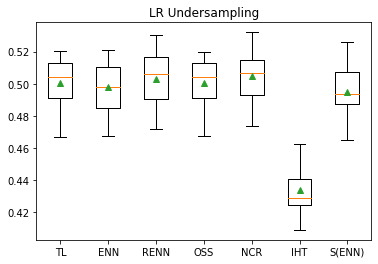

Starting:
SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



  US Model     Score       Std
0       TL  0.446351  0.011775
1      ENN  0.446351  0.011775
2     RENN  0.446351  0.011775
3      OSS  0.446351  0.011775
4      NCR  0.446351  0.011775
5   S(ENN)  0.446351  0.011775
6      IHT  0.446302  0.011816


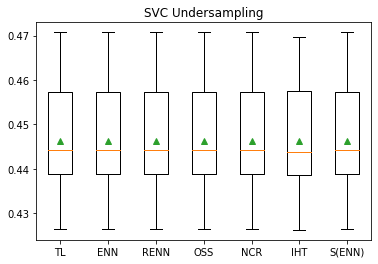

Starting:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')



  US Model     Score       Std
0      NCR  0.476729  0.016910
1     RENN  0.448390  0.016373
2      ENN  0.439415  0.015597
3   S(ENN)  0.436368  0.012492
4       TL  0.380638  0.024651
5      IHT  0.358004  0.007261
6      OSS  0.357702  0.021385


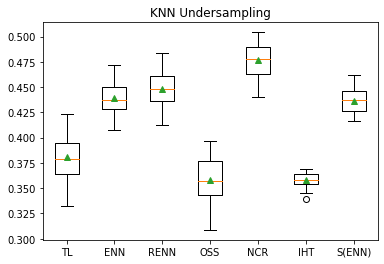

Starting:
DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')



  US Model     Score       Std
0      NCR  0.445706  0.011067
1   S(ENN)  0.436914  0.011394
2     RENN  0.429181  0.011976
3      ENN  0.422989  0.013689
4       TL  0.394080  0.014504
5      OSS  0.393908  0.013699
6      IHT  0.345978  0.006465


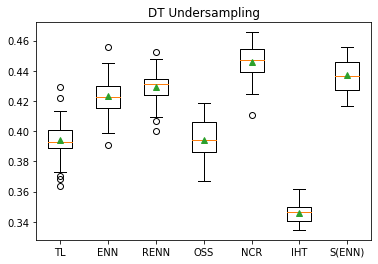

Starting:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)



  US Model     Score       Std
0      NCR  0.470034  0.010784
1   S(ENN)  0.440486  0.012054
2     RENN  0.437031  0.013528
3      ENN  0.432750  0.013726
4       TL  0.412958  0.015821
5      OSS  0.412041  0.013064
6      IHT  0.351728  0.006271


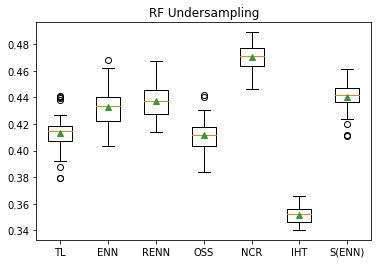

Starting:
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)



  US Model     Score       Std
0     RENN  0.505201  0.017732
1   S(ENN)  0.493328  0.014069
2      ENN  0.490871  0.018585
3      IHT  0.487937  0.020417
4      NCR  0.478179  0.019068
5       TL  0.342538  0.022134
6      OSS  0.342242  0.024534


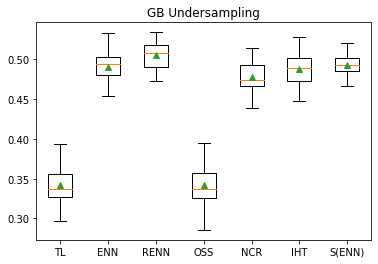

Starting:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)



  US Model     Score       Std
0      IHT  0.508208  0.013493
1     RENN  0.490705  0.016560
2   S(ENN)  0.479683  0.013604
3      ENN  0.475993  0.021703
4      NCR  0.473509  0.019413
5      OSS  0.303717  0.023204
6       TL  0.302348  0.024086


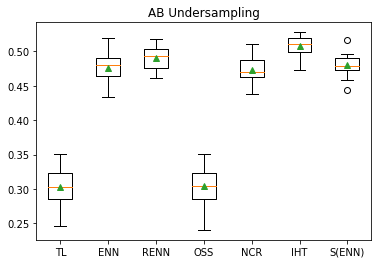

Starting:
GaussianNB(priors=None, var_smoothing=1e-09)



  US Model     Score       Std
0   S(ENN)  0.392689  0.015517
1      IHT  0.385080  0.044299
2      NCR  0.371411  0.011968
3      ENN  0.369638  0.012023
4       TL  0.367512  0.012157
5      OSS  0.367503  0.012128
6     RENN  0.364959  0.014280


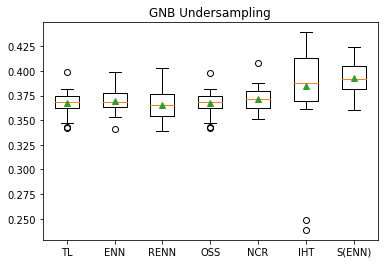

Starting:
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)



  US Model     Score       Std
0   S(ENN)  0.403938  0.012202
1      IHT  0.349837  0.011488
2     RENN  0.315567  0.010773
3      ENN  0.309826  0.013260
4      NCR  0.304824  0.015083
5       TL  0.303206  0.014882
6      OSS  0.303206  0.014882


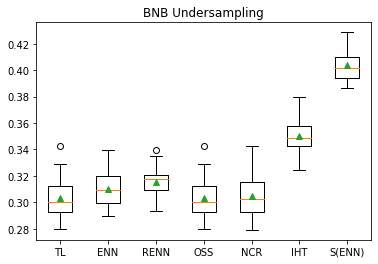

In [128]:
## evaluate undersampling models with ml models -- with holdout data removed
# fbeta weighted 1.5

# get features, encoded target
feats, targ = load_data(features)

sub_feats = feats[
    [
        'age_bin', 
        'contact', 
        'log_campaign', 
        'log_pdays',
        'pdays_contact',
        'previous', 
        'poutcome', 
        'emp.var.rate', 
        'cons.price.idx', 
        'cons.conf.idx', 
        'euribor3m', 
        'nr.employed', 
        'month_sin', 
        'month_cos', 
        'season_sin', 
        'season_cos'
    ]
]

# define ml models
ml_models, ml_names = get_ml_models()
# define undersampling models
us_models, us_names = get_us_models()

for ml in trange(1, len(ml_models) + 1, desc = 'Model....'):
    print(f'Starting:\n{ml_models[ml-1]}')
    # define scores list for plotting chart
    scores = []
    # define lists for dataframe
    us_model_list = []
    mean_scores = []
    std_list = []
    
    for us in trange(1, len(us_models) + 1, desc = 'US Model...'):
        # one hot encode, scale and evaluate undersampling model
        trans_feats = pd.get_dummies(sub_feats, drop_first = True)
        pipeline = Pipeline(
            steps = [
                ('sc', StandardScaler(with_mean = False)), 
                ('us', us_models[us-1]), 
                ('m', ml_models[ml-1])
            ]
        )
        score = evaluate_model(trans_feats, targ, pipeline)
        # append lists
        scores.append(score)
        us_model_list.append(us_names[us-1])
        mean_scores.append(np.mean(score))
        std_list.append(np.std(score))
        
    # create dataframe    
    us_df = pd.DataFrame({'US Model': us_model_list,
                          'Score': mean_scores,
                          'Std': std_list})
    # sort dataframe
    sorted_us_df = us_df.sort_values(by = 'Score', ascending = False).reset_index(drop = True) 
    # print dataframe
    print(sorted_us_df)
    # plot chart
    plt.boxplot(scores, labels = us_names, showmeans = True)
    plt.title(f'{ml_names[ml-1]} Undersampling')
    plt.show()

Starting:
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)



  US Model     Score       Std
0      OSS  0.470847  0.014927
1       TL  0.470821  0.014896
2      NCR  0.468956  0.014883
3      ENN  0.468947  0.014987
4     RENN  0.467671  0.015031
5   S(ENN)  0.465632  0.015484
6      IHT  0.464356  0.015174


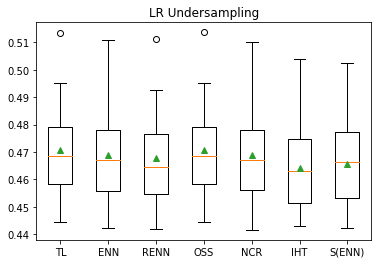

Starting:
SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



  US Model     Score       Std
0       TL  0.505882  0.015016
1      OSS  0.505760  0.014854
2      ENN  0.503216  0.015380
3      NCR  0.501785  0.014857
4   S(ENN)  0.500452  0.015517
5     RENN  0.500395  0.016209
6      IHT  0.485588  0.016592


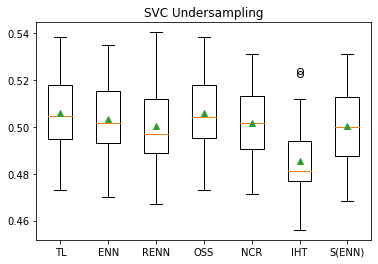

Starting:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')



  US Model     Score       Std
0      IHT  0.477500  0.013253
1     RENN  0.476655  0.011871
2      NCR  0.468775  0.016918
3      ENN  0.466285  0.012877
4   S(ENN)  0.434206  0.011050
5      OSS  0.372078  0.013432
6       TL  0.372068  0.015368


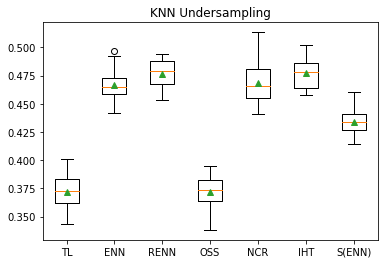

Starting:
DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')



  US Model     Score       Std
0   S(ENN)  0.418496  0.012075
1     RENN  0.414319  0.010497
2      IHT  0.411523  0.009712
3      ENN  0.405527  0.011375
4      NCR  0.401081  0.013135
5       TL  0.348092  0.015143
6      OSS  0.342077  0.013393


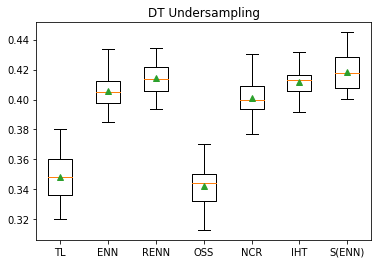

Starting:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  US Model     Score       Std
0      IHT  0.438395  0.009065
1      ENN  0.437951  0.013319
2     RENN  0.436355  0.010172
3      NCR  0.436321  0.012914
4   S(ENN)  0.428031  0.010183
5       TL  0.372693  0.014369
6      OSS  0.372120  0.017905


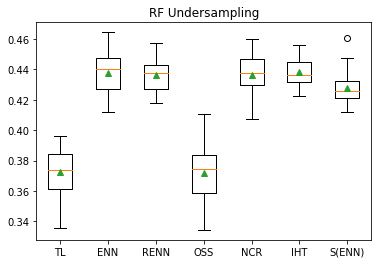

Starting:
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)



  US Model     Score       Std
0      IHT  0.515228  0.016529
1     RENN  0.496804  0.016111
2   S(ENN)  0.473432  0.013220
3      ENN  0.470949  0.017120
4      NCR  0.466114  0.018561
5      OSS  0.297416  0.022973
6       TL  0.297021  0.025793


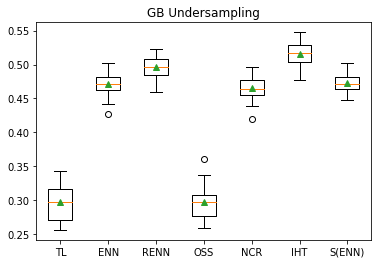

Starting:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)



  US Model     Score       Std
0      IHT  0.498121  0.014048
1     RENN  0.471200  0.017104
2   S(ENN)  0.457274  0.012192
3      ENN  0.439062  0.020607
4      NCR  0.432511  0.023956
5       TL  0.296848  0.024545
6      OSS  0.296334  0.023556


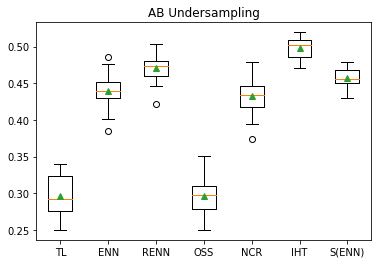

Starting:
GaussianNB(priors=None, var_smoothing=1e-09)



  US Model     Score       Std
0     RENN  0.454893  0.015084
1      IHT  0.445267  0.010315
2      ENN  0.443219  0.015212
3      NCR  0.439366  0.015297
4   S(ENN)  0.437387  0.009778
5      OSS  0.421498  0.017038
6       TL  0.421420  0.016753


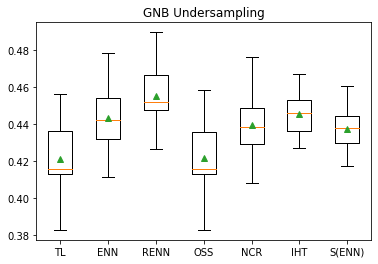

Starting:
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)



  US Model     Score       Std
0   S(ENN)  0.392358  0.009106
1      IHT  0.390459  0.020352
2     RENN  0.340631  0.019759
3      ENN  0.303106  0.021413
4      NCR  0.300323  0.019244
5       TL  0.129986  0.018255
6      OSS  0.129181  0.016349


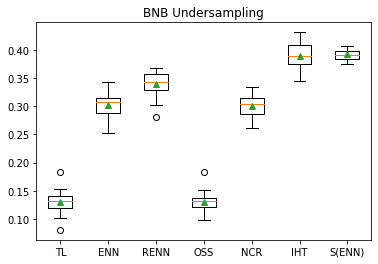

In [131]:
## evaluate undersampling models with ml models and pca -- with holdout data removed
# fbeta weighted 1.5

# get features, encoded target
feats, targ = load_data(features)

# define ml models
ml_models, ml_names = get_ml_models()
# define undersampling models
us_models, us_names = get_us_models()

for ml in trange(1, len(ml_models) + 1, desc = 'Model....'):
    print(f'Starting:\n{ml_models[ml-1]}')
    # define scores list for plotting chart
    scores = []
    # define lists for dataframe
    us_model_list = []
    mean_scores = []
    std_list = []
    
    for us in trange(1, len(us_models) + 1, desc = 'US Model...'):
        # one hot encode, scale and evaluate undersampling model
        trans_feats = pd.get_dummies(feats, drop_first = True)
        pipeline = Pipeline(
            steps = [
                ('sc', StandardScaler(with_mean = False)), 
                ('us', us_models[us-1]),
                ('pca', PCA(n_components = 12)),
                ('m', ml_models[ml-1])
            ]
        )
        score = evaluate_model(trans_feats, targ, pipeline)
        # append lists
        scores.append(score)
        us_model_list.append(us_names[us-1])
        mean_scores.append(np.mean(score))
        std_list.append(np.std(score))
        
    # create dataframe    
    us_df = pd.DataFrame({'US Model': us_model_list,
                          'Score': mean_scores,
                          'Std': std_list})
    # sort dataframe
    sorted_us_df = us_df.sort_values(by = 'Score', ascending = False).reset_index(drop = True) 
    # print dataframe
    print(sorted_us_df)
    # plot chart
    plt.boxplot(scores, labels = us_names, showmeans = True)
    plt.title(f'{ml_names[ml-1]} Undersampling')
    plt.show()

With fbeta weighted at 1.5; logistic regression with NCR undersampling, gradient boosting with RENN undersampling and adaboost with IHT undersampling all produced similar scores between 0.505 and 0.508.

With PCA reduced features SVC with TL undersampling produced a score of 0.506 and gradient boosting with IHT undersampling obtained 0.515.

Gradient boosting with one sided selection undersampling produced the best score of 0.510520

## -- Oversampling --

Starting:
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)



  OS Model     Score       Std
0     SVMS  0.507214  0.015340
1        S  0.493183  0.013284
2       AS  0.475476  0.013818
3       BS  0.470933  0.013018


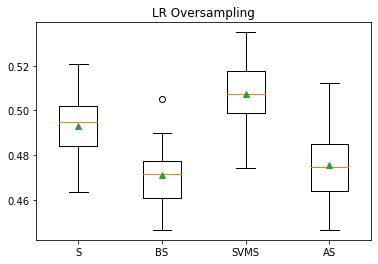

Starting:
SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



  OS Model     Score       Std
0     SVMS  0.446975  0.012039
1        S  0.446351  0.011775
2       BS  0.446351  0.011775
3       AS  0.446351  0.011775


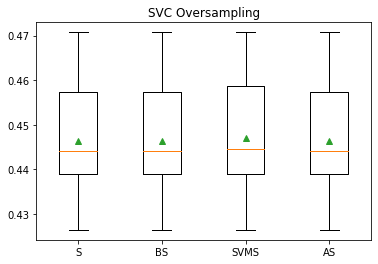

Starting:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  OS Model     Score       Std
0        S  0.464284  0.019407
1     SVMS  0.452898  0.015191
2       AS  0.452808  0.016151
3       BS  0.451237  0.016498


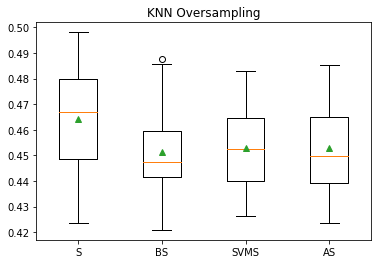

Starting:
DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')



  OS Model     Score       Std
0        S  0.428088  0.014777
1     SVMS  0.374189  0.019201
2       AS  0.362788  0.017932
3       BS  0.350827  0.014299


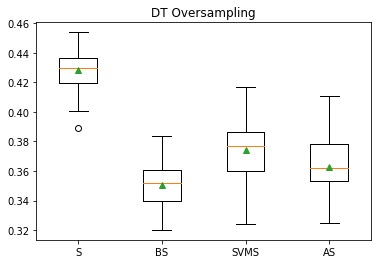

Starting:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  OS Model     Score       Std
0        S  0.450098  0.015710
1     SVMS  0.416531  0.017447
2       AS  0.394160  0.017190
3       BS  0.384873  0.013758


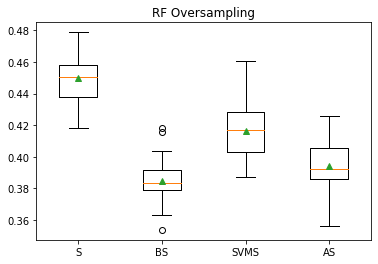

Starting:
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)



  OS Model     Score       Std
0     SVMS  0.518468  0.014760
1        S  0.515983  0.014172
2       BS  0.496022  0.014497
3       AS  0.494238  0.013845


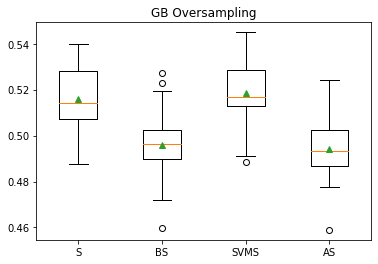

Starting:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)


C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  OS Model     Score       Std
0        S  0.509805  0.015534
1     SVMS  0.506846  0.016408
2       BS  0.482171  0.014150
3       AS  0.476122  0.012491


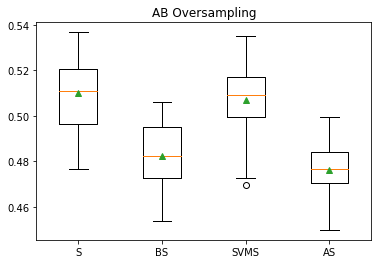

Starting:
GaussianNB(priors=None, var_smoothing=1e-09)


C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  OS Model     Score       Std
0       BS  0.439344  0.014009
1       AS  0.404443  0.013743
2     SVMS  0.395973  0.012839
3        S  0.389320  0.012722


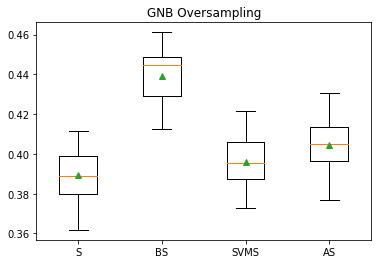

Starting:
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)



  OS Model     Score       Std
0       BS  0.413997  0.010134
1       AS  0.410093  0.011147
2     SVMS  0.339353  0.015204
3        S  0.325522  0.011909


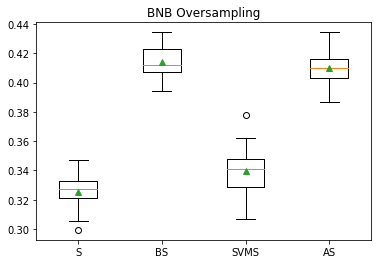

In [130]:
## evaluate oversampling models with models ---- with holdout data removed
# fbeat weighted 1.5

# get features, encoded target
feats, targ = load_data(features)

sub_feats = feats[
    [
        'age_bin', 
        'contact', 
        'log_campaign', 
        'log_pdays',
        'pdays_contact',
        'previous', 
        'poutcome', 
        'emp.var.rate', 
        'cons.price.idx', 
        'cons.conf.idx', 
        'euribor3m', 
        'nr.employed', 
        'month_sin', 
        'month_cos', 
        'season_sin', 
        'season_cos'
    ]
]

# define ml models
ml_models, ml_names = get_ml_models()
# define oversampling models
os_models, os_names = get_os_models()

for ml in trange(1, len(ml_models) + 1, desc = 'Model....'):
    print(f'Starting:\n{ml_models[ml-1]}')
    # define scores list for plotting chart
    scores = []
    # define lists for dataframe
    os_model_list = []
    mean_scores = []
    std_list = []
    
    for os in trange(1, len(os_models) + 1, desc = 'OS Model...'):
        # one hot encode, scale and evaluate undersampling model
        trans_feats = pd.get_dummies(sub_feats, drop_first = True)
        # if model is SMOTE allow for random undersampling
        if os_names[os-1] == 'S':
            rus = RandomUnderSampler(sampling_strategy = 0.5)
            pipeline = Pipeline(steps = [('sc', StandardScaler(with_mean = False)), 
                                         ('os', os_models[os-1]), 
                                         ('rus', rus), 
                                         ('m', ml_models[ml-1])])
            score = evaluate_model(trans_feats, targ, pipeline)
        else:
            pipeline = Pipeline(steps = [('sc', StandardScaler(with_mean = False)), 
                                         ('os', os_models[os-1]), 
                                         ('m', ml_models[ml-1])])
            score = evaluate_model(trans_feats, targ, pipeline)
        # append lists
        scores.append(score)
        os_model_list.append(os_names[os-1])
        mean_scores.append(np.mean(score))
        std_list.append(np.std(score))
        
    # create dataframe    
    os_df = pd.DataFrame({'OS Model': os_model_list,
                          'Score': mean_scores,
                          'Std': std_list})
    # sort dataframe
    sorted_os_df = os_df.sort_values(by = 'Score', ascending = False).reset_index(drop = True) 
    # print dataframe
    print(sorted_os_df)
    # plot chart
    plt.boxplot(scores, labels = os_names, showmeans = True)
    plt.title(f'{ml_names[ml-1]} Oversampling')
    plt.show()

Starting:
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)



  OS Model     Score       Std
0     SVMS  0.472734  0.017050
1        S  0.469651  0.014546
2       BS  0.460079  0.013485
3       AS  0.460065  0.013456


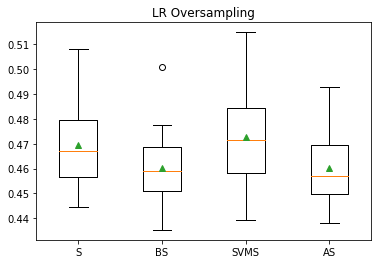

Starting:
SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



  OS Model     Score       Std
0     SVMS  0.518635  0.013740
1        S  0.495707  0.015263
2       BS  0.486063  0.013544
3       AS  0.478559  0.015194


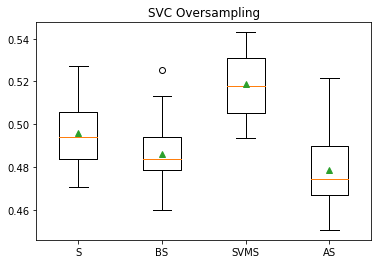

Starting:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  OS Model     Score       Std
0     SVMS  0.455795  0.013792
1        S  0.450552  0.014458
2       BS  0.449237  0.014036
3       AS  0.441261  0.015306


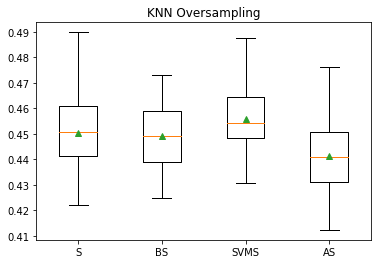

Starting:
DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  OS Model     Score       Std
0     SVMS  0.381877  0.019837
1        S  0.380573  0.015095
2       AS  0.368825  0.013645
3       BS  0.357304  0.017596


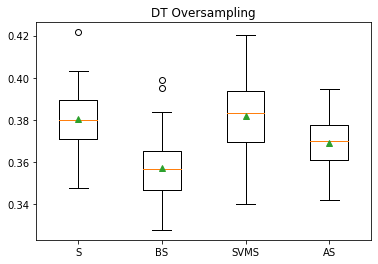

Starting:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  OS Model     Score       Std
0        S  0.432206  0.011627
1     SVMS  0.426791  0.014995
2       BS  0.421751  0.014890
3       AS  0.421543  0.014295


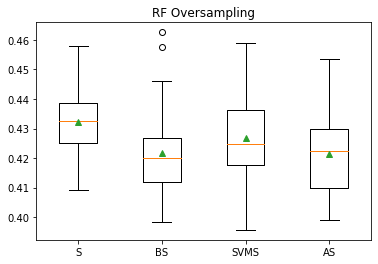

Starting:
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)



  OS Model     Score       Std
0     SVMS  0.517086  0.016384
1        S  0.510786  0.018311
2       BS  0.487399  0.013264
3       AS  0.480553  0.012217


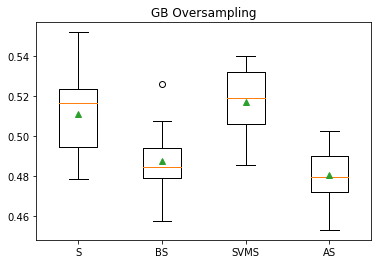

Starting:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)


C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  OS Model     Score       Std
0     SVMS  0.496264  0.016164
1        S  0.488891  0.017161
2       BS  0.475771  0.014844
3       AS  0.469018  0.012493


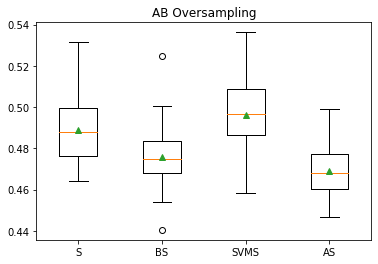

Starting:
GaussianNB(priors=None, var_smoothing=1e-09)


C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  OS Model     Score       Std
0       BS  0.456591  0.010373
1       AS  0.453114  0.012487
2     SVMS  0.441878  0.014424
3        S  0.436241  0.017295


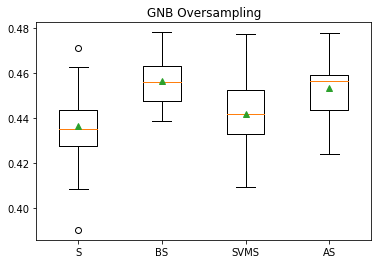

Starting:
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)


C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



  OS Model     Score       Std
0        S  0.431444  0.013737
1     SVMS  0.425691  0.018301
2       BS  0.424071  0.016954
3       AS  0.417720  0.009413


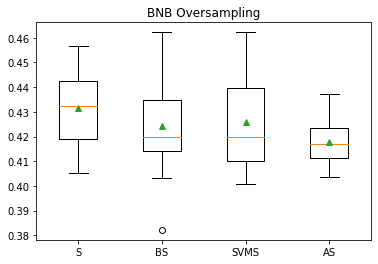

In [57]:
## evaluate oversampling models with ml models and PCA ---- with holdout data removed
# fbeta weighted 1.5

# get features, encoded target
feats, targ = load_data(features)

# define ml models
ml_models, ml_names = get_ml_models()
# define oversampling models
os_models, os_names = get_os_models()

for ml in trange(1, len(ml_models) + 1, desc = 'Model....'):
    print(f'Starting:\n{ml_models[ml-1]}')
    # define scores list for plotting chart
    scores = []
    # define lists for dataframe
    os_model_list = []
    mean_scores = []
    std_list = []
    
    for os in trange(1, len(os_models) + 1, desc = 'OS Model...'):
        # one hot encode, scale and evaluate undersampling model
        trans_feats = pd.get_dummies(feats, drop_first = True)
        # if model is SMOTE allow for random undersampling
        if os_names[os-1] == 'S':
            rus = RandomUnderSampler(sampling_strategy = 0.5)
            pipeline = Pipeline(
                steps = [
                    ('sc', StandardScaler(with_mean = False)), 
                    ('os', os_models[os-1]), 
                    ('rus', rus),
                    ('pca', PCA(n_components = 11)),
                    ('m', ml_models[ml-1])
                ]
            )
            score = evaluate_model(trans_feats, targ, pipeline)
        else:
            pipeline = Pipeline(
                steps = [
                    ('sc', StandardScaler(with_mean = False)), 
                    ('os', os_models[os-1]), 
                    ('pca', PCA(n_components = 11)),
                    ('m', ml_models[ml-1])
                ]
            )
            score = evaluate_model(trans_feats, targ, pipeline)
        # append lists
        scores.append(score)
        os_model_list.append(os_names[os-1])
        mean_scores.append(np.mean(score))
        std_list.append(np.std(score))
        
    # create dataframe    
    os_df = pd.DataFrame({'OS Model': os_model_list,
                          'Score': mean_scores,
                          'Std': std_list})
    # sort dataframe
    sorted_os_df = os_df.sort_values(by = 'Score', ascending = False).reset_index(drop = True) 
    # print dataframe
    print(sorted_os_df)
    # plot chart
    plt.boxplot(scores, labels = os_names, showmeans = True)
    plt.title(f'{ml_names[ml-1]} Oversampling')
    plt.show()

With Fbeta weighted 1.5; gradient boosting with SVM smote oversampling produced the best score of 0.518, logistic regression with SVM smote and adaboost with smote obtained similar scores between 0.507 and 0.51

With PCA reduced features gradient boosting with SVM smote and SVC with SVM smote produced similar scores between 0.517 and 0.519

As we can see oversampling has produced the better results and we can take gradient boosting with SVM smote, adaboost with smote and SVC with pca reduced features and SVM smote models to explore further.

We can run feature selection on the gradient boosting with SVM smote and adaboost with smote models to see if anymore performance can be gained. We can then run model tuning on all 3 models to achieve optimal model performance.

### Feature Selection

In [58]:
# fbeta weighted 1.5, feature selection - logistic regression with svms oversampling

subset_df = features[
    [
        'age_bin', 
        'contact', 
        'log_campaign', 
        'log_pdays',
        'pdays_contact',
        'previous', 
        'poutcome', 
        'emp.var.rate', 
        'cons.price.idx', 
        'cons.conf.idx', 
        'euribor3m', 
        'nr.employed', 
        'month_sin', 
        'month_cos', 
        'season_sin', 
        'season_cos',
        'y'
    ]
]

model = LogisticRegression(solver = 'liblinear', class_weight = 'balanced', random_state = 42)
sequential_forward_feature_selection(model, subset_df, sampling = SVMSMOTE())

C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the execut

C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the execut

C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the execut

Optimal features reached......


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Best Features:
['nr.employed', 'month_cos', 'season_cos', 'age_bin', 'poutcome', 'month_sin', 'log_campaign', 'cons.conf.idx', 'season_sin']

Score: 0.5079299921514708        Std: 0.016229317930408604


In [63]:
# fbeta weighted 1.5, feature selection - gradient boosting with svms oversampling

subset_df = features[
    [
        'age_bin', 
        'contact', 
        'log_campaign', 
        'log_pdays',
        'pdays_contact',
        'previous', 
        'poutcome', 
        'emp.var.rate', 
        'cons.price.idx', 
        'cons.conf.idx', 
        'euribor3m', 
        'nr.employed', 
        'month_sin', 
        'month_cos', 
        'season_sin', 
        'season_cos',
        'y'
    ]
]

model = GradientBoostingClassifier(n_estimators = 100, max_features = 'sqrt', verbose = 1)
sequential_forward_feature_selection(model, subset_df, sampling = SVMSMOTE())

C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the execut

C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\jakee\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the execut

Optimal features reached......


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

Best Features:
['euribor3m', 'season_sin', 'age_bin', 'season_cos', 'cons.price.idx']

Score: 0.5231788890091269        Std: 0.019186411050488083


In [67]:
# fbeta weighted 1.5, feature selection - adaboost with smote oversampling

subset_df = features[
    [
        'age_bin', 
        'contact', 
        'log_campaign', 
        'log_pdays',
        'pdays_contact',
        'previous', 
        'poutcome', 
        'emp.var.rate', 
        'cons.price.idx', 
        'cons.conf.idx', 
        'euribor3m', 
        'nr.employed', 
        'month_sin', 
        'month_cos', 
        'season_sin', 
        'season_cos',
        'y'
    ]
]

model = AdaBoostClassifier(n_estimators = 50)
sequential_forward_feature_selection(
    model, 
    subset_df, 
    sampling = SMOTE(sampling_strategy = 0.2), 
    combined_sampling = RandomUnderSampler(sampling_strategy = 0.5)
)

Optimal features reached......


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

Best Features:
['cons.conf.idx', 'age_bin', 'poutcome', 'season_cos']

Score: 0.5135587999158918        Std: 0.014190075925771678


## -- Hyperparameter Tuning --

In [66]:
## gradient boosting hyperparameter tuning - fbeta weighted 1.5
feats, targ = load_data(features)

sub_feats = feats[
    [
        'age_bin',
        'cons.price.idx',  
        'euribor3m',
        'season_sin',
        'season_cos' 
    ]
]

sub_feats = pd.get_dummies(sub_feats, drop_first = True)

model = GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 60,
    max_depth = 11,
    min_samples_split = 1200,
    min_samples_leaf = 50,
    max_features = 3,
    subsample = 1.0,
    random_state = 42
)
svms = SVMSMOTE()
sc = StandardScaler(with_mean = False)

pipeline = Pipeline(
    steps = [
        ('sc', sc),
        ('os', svms),
        ('model', model)
    ]
)

params = {
    'model__n_estimators': range(50,501,50)
}

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

metric = make_scorer(f2)
                             
grid_search = GridSearchCV(pipeline, params, n_jobs = -1, scoring = metric, cv = cv, verbose = 2)
grid_search.fit(sub_feats, targ)
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Gradient Boosting (learning_rate: 0.025) (n_stimators: range(50,501,50)) GridSearch:\nBest Score: {best_score}        Best Parameters: {best_params}')

Fitting 30 folds for each of 10 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.0min finished


Gradient Boosting (learning_rate: 0.025) (n_stimators: range(50,501,50)) GridSearch:
Best Score: 0.5290670764849355        Best Parameters: {'model__n_estimators': 250}


In [ ]:
"""
baseline: 0.292, simple model: 0.28

Gradient Boosting Initial (n_estimators: range(50,151,10))  GridSearch:
Best Score: 0.5290404204192289        Best Parameters: {'model__n_estimators': 60}

Gradient Boosting (max_depth: range(5,16,2)) (min_samples_split: range(500,1501,100))  GridSearch:
Best Score: 0.5298850102635662        Best Parameters: {'model__max_depth': 11, 'model__min_samples_split': 1200}

Gradient Boosting (min_samples_leaf: range(10,101,10))  GridSearch:
Best Score: 0.5291369105996232        Best Parameters: {'model__min_samples_leaf': 50}

Gradient Boosting (max_features: range(2,6,1)) (subsample: [0.5,0.6,0.7,0.8,0.9,1.0])  GridSearch:
Best Score: 0.5301557854277792        Best Parameters: {'model__max_features': 3, 'model__subsample': 1.0}

Gradient Boosting (learning_rate: 0.1) (n_stimators: range(100,701,50)) GridSearch:
Best Score: 0.5252118669682554        Best Parameters: {'model__n_estimators': 100}
Gradient Boosting (learning_rate: 0.1) (n_stimators: range(40,101,10)) GridSearch:
Best Score: 0.5283676044182924        Best Parameters: {'model__n_estimators': 40}
Gradient Boosting (learning_rate: 0.1) (n_stimators: range(20,41,5)) GridSearch:
Best Score: 0.5296015347843648        Best Parameters: {'model__n_estimators': 40}
Gradient Boosting (learning_rate: 0.05) (n_stimators: range(100,501,50)) GridSearch:
Best Score: 0.5288289053396011        Best Parameters: {'model__n_estimators': 100}
Gradient Boosting (learning_rate: 0.05) (n_stimators: range(30,151,10)) GridSearch:
Best Score: 0.530480567677133        Best Parameters: {'model__n_estimators': 60}
Gradient Boosting (learning_rate: 0.025) (n_stimators: range(50,501,50)) GridSearch:
Best Score: 0.5290670764849355        Best Parameters: {'model__n_estimators': 250}

"""

In [57]:
## adaboost hyperparameter tuning - fbeta weighted 1.5
feats, targ = load_data(features)

sub_feats = feats[
    [
        'age_bin', 
        'poutcome',
        'cons.conf.idx',
        'season_sin',
        'season_cos'
    ]
]

sub_feats = pd.get_dummies(sub_feats, drop_first = True)

model = AdaBoostClassifier(
    algorithm = 'SAMME.R',
    learning_rate = 0.1,
    n_estimators = 1200,
    random_state = 42
)
smote = SMOTE(sampling_strategy = 0.4)
rus = RandomUnderSampler(sampling_strategy = 0.6)
sc = StandardScaler(with_mean = False)

pipeline = Pipeline(
    steps = [
        ('sc', sc),
        ('os', smote),
        ('rus', rus),
        ('model', model)
    ]
)

params = {
    'os__k_neighbors': range(3,14,2)
}

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

metric = make_scorer(f2)
                             
grid_search = GridSearchCV(pipeline, params, n_jobs = -1, scoring = metric, cv = cv, verbose = 2)
grid_search.fit(sub_feats, targ)
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Adaboost (smote__k_neighbors: range(3,14,2))GridSearch:\nBest Score: {best_score}        Best Parameters: {best_params}')

Fitting 30 folds for each of 6 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  9.2min finished


Adaboost (smote__k_neighbors: range(3,14,2))GridSearch:
Best Score: 0.5152903826413702        Best Parameters: {'os__k_neighbors': 11}


In [ ]:
"""
baseline 0.292, simple model 0.28

Adaboost GridSearch:
Best Score: 0.503855574867207        
Best Parameters: {'model__algorithm': 'SAMME.R', 'model__learning_rate': 0.075, 'model__n_estimators': 450}

Adaboost GridSearch:
Best Score: 0.5069673581923074        
Best Parameters: {'model__algorithm': 'SAMME.R', 'model__learning_rate': 0.075, 'model__n_estimators': 1000}

Adaboost GridSearch:
Best Score: 0.5116755108265995        Best Parameters: {'os__sampling_strategy': 0.4, 'rus__sampling_strategy': 0.6}

Adaboost GridSearch:
Best Score: 0.5155143349757948        
Best Parameters: {'model__algorithm': 'SAMME.R', 'model__learning_rate': 0.1, 'model__n_estimators': 1200}

Adaboost (smote__k_neighbors: range(3,14,2))GridSearch:
Best Score: 0.5152903826413702        Best Parameters: {'os__k_neighbors': 11}
"""

In [ ]:
## logistic regression hyperparameter tuning - fbeta weighted 1.5
feats, targ = load_data(features)

sub_feats = feats[
    [
        'age_bin',   
        'log_campaign',
        'poutcome',
        'cons.conf.idx',
        'nr.employed',
        'month_sin',
        'month_cos', 
        'season_sin',
        'season_cos'
    ]
]

sub_feats = pd.get_dummies(sub_feats, drop_first = True)

model = LogisticRegression(
    class_weight = 'balanced',
    solver = 'newton-cg',
    max_iter = 150,
    n_jobs = -1
)
svms = SVMSMOTE()
sc = StandardScaler(with_mean = False)

pipeline = Pipeline(
    steps = [
        ('sc', sc),
        ('os', svms),
        ('model', model)
    ]
)

params = {
    'model__penalty': ['l1','l2'],
    'model__C': [0.2,0.4,0.6,0.8,1.0],
    'model__fit_intercept': [True, False]
}

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

metric = make_scorer(f2)
                             
grid_search = GridSearchCV(pipeline, params, n_jobs = -1, scoring = metric, cv = cv, verbose = 2)
grid_search.fit(sub_feats, targ)
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Logistic Regression (penalty: ['l1','l2']) (C: [0.2,0.4,0.6,0.8,1.0]) (fit_intercept: [True, False]) GridSearch:\nBest Score: {best_score}        Best Parameters: {best_params}")

In [ ]:
"""
baseline 0.292, simple model 0.28

Logistic Regression (solver: ['newton-cg','lbfgs','liblinear','sag','saga']) (max_iter: range(50,501,50)) GridSearch:
Best Score: 0.507819614103259        Best Parameters: {'model__max_iter': 150, 'model__solver': 'newton-cg'}

Logistic Regression (penalty: ['l1','l2']) (C: [0.2,0.4,0.6,0.8,1.0]) (fit_intercept: [True, False]) GridSearch:
Best Score: 0.50760368584145        Best Parameters: {'model__C': 0.4, 'model__fit_intercept': True, 'model__penalty': 'l2'}
"""

In [56]:
## svc pca hyperparameter tuning - fbeta weighted 1.5
feats, targ = load_data(features)

feats = pd.get_dummies(feats, drop_first = True)

model = SVC(
    kernel = 'rbf',
    class_weight = 'balanced',
    random_state = 42
)
svms = SVMSMOTE()
sc = StandardScaler(with_mean = False)

pipeline = Pipeline(
    steps = [
        ('sc', sc),
        ('os', svms),
        ('pca', PCA(n_components = 12)),
        ('model', model)
    ]
)

#

params = {
    'model__C': [0.2,0.4,0.6,0.8,1.0],
    'model__gamma': ['scale','auto']
}

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

metric = make_scorer(f2)
                             
grid_search = GridSearchCV(pipeline, params, n_jobs = -1, scoring = metric, cv = cv, verbose = 2)
grid_search.fit(feats, targ)
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"SVC (C: [0.2,0.4,0.6,0.8,1.0]) (gamma: ['scale','auto']) GridSearch:\nBest Score: {best_score}        Best Parameters: {best_params}")

Fitting 30 folds for each of 10 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 69.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 132.7min finished


SVC (C: [0.2,0.4,0.6,0.8,1.0]) (gamma: ['scale','auto']) GridSearch:
Best Score: 0.5225648680026965        Best Parameters: {'model__C': 0.4, 'model__gamma': 'auto'}


In [ ]:
"""
baseline 0.292, simple model 0.28

SVC (kernel: ['rbf','sigmoid','poly']) GridSearch:
Best Score: 0.520094530377552        Best Parameters: {'model__kernel': 'rbf'}

SVC (C: [0.2,0.4,0.6,0.8,1.0]) (gamma: ['scale','auto']) GridSearch:
Best Score: 0.5225648680026965        Best Parameters: {'model__C': 0.4, 'model__gamma': 'auto'}
"""

#### voting classifier model


  US Model     Score       Std
0     RENN  0.504293  0.017995
1   S(ENN)  0.493080  0.014626
2      IHT  0.489950  0.017742
3      ENN  0.488899  0.018364
4      NCR  0.475951  0.020278
5      OSS  0.344407  0.023091
6       TL  0.343285  0.026019


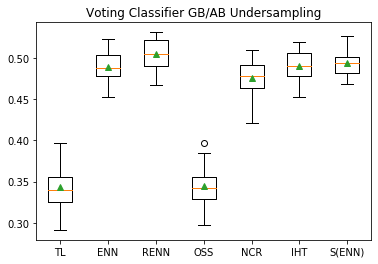

In [58]:
# undersampling voting classifier GB/AB - fbeta weighted 1.5
gb = GradientBoostingClassifier(n_estimators = 100, max_features = 'sqrt', verbose = 1, random_state = 42)
ab = AdaBoostClassifier(n_estimators = 50, random_state = 42)
vc = VotingClassifier([('gb', gb), ('ab', ab)], voting = 'soft', n_jobs = -1)

# get features, encoded target
feats, targ = load_data(features)

sub_feats = feats[
    [
        'age_bin', 
        'contact', 
        'log_campaign', 
        'log_pdays',
        'pdays_contact',
        'previous', 
        'poutcome', 
        'emp.var.rate', 
        'cons.price.idx', 
        'cons.conf.idx', 
        'euribor3m', 
        'nr.employed', 
        'month_sin', 
        'month_cos', 
        'season_sin', 
        'season_cos'
    ]
]

# define undersampling models
us_models, us_names = get_us_models()


# define scores list for plotting chart
scores = []
# define lists for dataframe
us_model_list = []
mean_scores = []
std_list = []

for us in trange(1, len(us_models) + 1, desc = 'US Model...'):
    # one hot encode, scale and evaluate undersampling model
    trans_feats = pd.get_dummies(sub_feats, drop_first = True)
    pipeline = Pipeline(
        steps = [
            ('sc', StandardScaler(with_mean = False)), 
            ('us', us_models[us-1]), 
            ('m', vc)
        ]
    )
    score = evaluate_model(trans_feats, targ, pipeline)
    # append lists
    scores.append(score)
    us_model_list.append(us_names[us-1])
    mean_scores.append(np.mean(score))
    std_list.append(np.std(score))

# create dataframe    
us_df = pd.DataFrame({'US Model': us_model_list,
                      'Score': mean_scores,
                      'Std': std_list})
# sort dataframe
sorted_us_df = us_df.sort_values(by = 'Score', ascending = False).reset_index(drop = True) 
# print dataframe
print(sorted_us_df)
# plot chart
plt.boxplot(scores, labels = us_names, showmeans = True)
plt.title(f'Voting Classifier GB/AB Undersampling')
plt.show()


  OS Model     Score       Std
0     SVMS  0.518720  0.014445
1        S  0.514724  0.015692
2       BS  0.496337  0.014102
3       AS  0.492577  0.014463


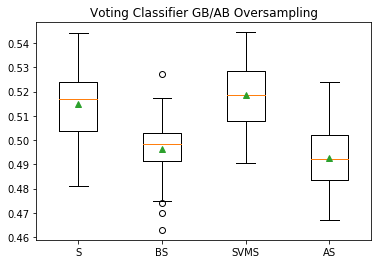

In [61]:
# oversampling voting classifier GB/AB - fbeta weighted 1.5
gb = GradientBoostingClassifier(n_estimators = 100, max_features = 'sqrt', verbose = 1, random_state = 42)
ab = AdaBoostClassifier(n_estimators = 50, random_state = 42)
vc = VotingClassifier([('gb', gb), ('ab', ab)], voting = 'soft', n_jobs = -1)

# get features, encoded target
feats, targ = load_data(features)

sub_feats = feats[
    [
        'age_bin', 
        'contact', 
        'log_campaign', 
        'log_pdays',
        'pdays_contact',
        'previous', 
        'poutcome', 
        'emp.var.rate', 
        'cons.price.idx', 
        'cons.conf.idx', 
        'euribor3m', 
        'nr.employed', 
        'month_sin', 
        'month_cos', 
        'season_sin', 
        'season_cos'
    ]
]

# define oversampling models
os_models, os_names = get_os_models()

# define scores list for plotting chart
scores = []
# define lists for dataframe
os_model_list = []
mean_scores = []
std_list = []

for os in trange(1, len(os_models) + 1, desc = 'OS Model...'):
    # one hot encode, scale and evaluate undersampling model
    trans_feats = pd.get_dummies(sub_feats, drop_first = True)
    # if model is SMOTE allow for random undersampling
    if os_names[os-1] == 'S':
        rus = RandomUnderSampler(sampling_strategy = 0.5)
        pipeline = Pipeline(steps = [('sc', StandardScaler(with_mean = False)), 
                                     ('os', os_models[os-1]), 
                                     ('rus', rus), 
                                     ('m', vc)])
        score = evaluate_model(trans_feats, targ, pipeline)
    else:
        pipeline = Pipeline(steps = [('sc', StandardScaler(with_mean = False)), 
                                     ('os', os_models[os-1]), 
                                     ('m', vc)])
        score = evaluate_model(trans_feats, targ, pipeline)
    # append lists
    scores.append(score)
    os_model_list.append(os_names[os-1])
    mean_scores.append(np.mean(score))
    std_list.append(np.std(score))

# create dataframe    
os_df = pd.DataFrame({'OS Model': os_model_list,
                      'Score': mean_scores,
                      'Std': std_list})
# sort dataframe
sorted_os_df = os_df.sort_values(by = 'Score', ascending = False).reset_index(drop = True) 
# print dataframe
print(sorted_os_df)
# plot chart
plt.boxplot(scores, labels = os_names, showmeans = True)
plt.title(f'Voting Classifier GB/AB Oversampling')
plt.show()

In [69]:
# voting classifier GB/AB feature selection
subset_df = features[
    [
        'age_bin', 
        'contact', 
        'log_campaign', 
        'log_pdays',
        'pdays_contact',
        'previous', 
        'poutcome', 
        'emp.var.rate', 
        'cons.price.idx', 
        'cons.conf.idx', 
        'euribor3m', 
        'nr.employed', 
        'month_sin', 
        'month_cos', 
        'season_sin', 
        'season_cos',
        'y'
    ]
]

gb = GradientBoostingClassifier(n_estimators = 100, max_features = 'sqrt', verbose = 1, random_state = 42)
ab = AdaBoostClassifier(n_estimators = 50, random_state = 42)
vc = VotingClassifier([('gb', gb), ('ab', ab)], voting = 'soft', n_jobs = -1)

sequential_forward_feature_selection(
    vc, 
    subset_df, 
    sampling = SMOTE(sampling_strategy = 0.2, k_neighbors = 13), 
    combined_sampling = RandomUnderSampler(sampling_strategy = 0.6)
)

Optimal features reached......


VotingClassifier(estimators=[('gb',
                              GradientBoostingClassifier(ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=3,
                                                         max_features='sqrt',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
           

In [86]:
## voting classifier hyperparameter tuning - fbeta weighted 1.5 -- all top features
feats, targ = load_data(features)

sub_feats = feats[
    [
        'age_bin',  
        'previous', 
        'poutcome', 
        'emp.var.rate',
        'euribor3m', 
        'nr.employed',  
        'season_sin', 
        'season_cos',
    ]
]

sub_feats = pd.get_dummies(sub_feats, drop_first = True)

gb = GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 250,
    max_depth = 9,
    min_samples_split = 1500,
    min_samples_leaf = 140,
    max_features = 3,
    subsample = 0.8,
    random_state = 42
)
ab = AdaBoostClassifier(
    algorithm = 'SAMME.R',
    learning_rate = 0.75,
    n_estimators = 450,
    random_state = 42
)
vc = VotingClassifier([('gb', gb), ('ab', ab)], voting = 'soft', n_jobs = -1)

smote = SMOTE(sampling_strategy = 0.4, k_neighbors = 5)
rus = RandomUnderSampler(sampling_strategy = 0.6)
sc = StandardScaler(with_mean = False)

pipeline = Pipeline(
    steps = [
        ('sc', sc),
        ('os', smote),
        ('rus', rus),
        ('model', vc)
    ]
)

params = {
    'model__gb__n_estimators': range(1000,1401,50)
}

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

metric = make_scorer(f2)
                             
grid_search = GridSearchCV(pipeline, params, n_jobs = -1, scoring = metric, cv = cv, verbose = 2)
grid_search.fit(sub_feats, targ)
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'VC Gradient Boosting (learning_rate: 0.01) (n_estimators: range(1000,1401,50)) GridSearch:\nBest Score: {best_score}        Best Parameters: {best_params}')

Fitting 30 folds for each of 9 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 18.0min finished


VC Gradient Boosting (learning_rate: 0.01) (n_estimators: range(1000,1401,50)) GridSearch:
Best Score: 0.5317334777621121        Best Parameters: {'model__gb__n_estimators': 1200}


In [ ]:
"""
Smote GridSearch:
Best Score: 0.5268598961277952        Best Parameters: {'os__sampling_strategy': 0.4, 'rus__sampling_strategy': 0.6}
Smote GridSearch:
Best Score: 0.5266450365555114        Best Parameters: {'os__k_neighbors': 5}

VC Adaboost GridSearch:
Best Score: 0.527158114179975        
Best Parameters: {'model__ab__algorithm': 'SAMME.R', 'model__ab__learning_rate': 0.75, 'model__ab__n_estimators': 450}

VC Gradient Boosting (n_estimators: range(50,151,10)) GridSearch:
Best Score: 0.5295545310267765        Best Parameters: {'model__gb__n_estimators': 120}
VC Gradient Boosting (max_depth: range(5,16,2)) (min_samples_split: range(500,1501,100)) GridSearch:
Best Score: 0.5300137709018081        Best Parameters: {'model__gb__max_depth': 9, 'model__gb__min_samples_split': 1500}
VC Gradient Boosting (max_depth: range(5,16,2)) (min_samples_split: range(1500,2001,100)) GridSearch:
Best Score: 0.5304903202186289        Best Parameters: {'model__gb__max_depth': 9, 'model__gb__min_samples_split': 1500}
VC Gradient Boosting (min_samples_leaf: range(10,101,10)) GridSearch:
Best Score: 0.531081906267943        Best Parameters: {'model__gb__min_samples_leaf': 100}
VC Gradient Boosting (min_samples_leaf: range(100,151,10)) GridSearch:
Best Score: 0.5314619875066277        Best Parameters: {'model__gb__min_samples_leaf': 140}
VC Gradient Boosting (max_features: range(2,9,1)) GridSearch:
Best Score: 0.5314233971042405        Best Parameters: {'model__gb__max_features': 3}
VC Gradient Boosting (subsample: [0.5,0.6,0.7,0.8,0.9,1.0]) GridSearch:
Best Score: 0.5317527573214976        Best Parameters: {'model__gb__subsample': 0.8}
VC Gradient Boosting (learning_rate: 0.1) (n_estimators: range(100,1001,50)) GridSearch:
Best Score: 0.5317368433037427        Best Parameters: {'model__gb__n_estimators': 100}
VC Gradient Boosting (learning_rate: 0.1) (n_estimators: range(50,101,10)) GridSearch:
Best Score: 0.5306713684330728        Best Parameters: {'model__gb__n_estimators': 90}
VC Gradient Boosting (learning_rate: 0.05) (n_estimators: range(100,701,10)) GridSearch:
Best Score: 0.5324723184608763        Best Parameters: {'model__gb__n_estimators': 250}
VC Gradient Boosting (learning_rate: 0.025) (n_estimators: range(100,701,10)) GridSearch:
Best Score: 0.531947267488073        Best Parameters: {'model__gb__n_estimators': 500}
VC Gradient Boosting (learning_rate: 0.01) (n_estimators: range(400,1001,50)) GridSearch:
Best Score: 0.5324608052441779        Best Parameters: {'model__gb__n_estimators': 1000}
VC Gradient Boosting (learning_rate: 0.01) (n_estimators: range(1000,1401,50)) GridSearch:
Best Score: 0.5317334777621121        Best Parameters: {'model__gb__n_estimators': 1200}
"""

# - Final Model -


Processing GB model

GB Confusion Matrix:
       P_Neg  P_Pos
A_Neg   3259    396
A_Pos    184    280

Processing AB model

AB Confusion Matrix:
       P_Neg  P_Pos
A_Neg   3246    409
A_Pos    183    281

Processing VC(GBAB) model

VC(GBAB) Confusion Matrix:
       P_Neg  P_Pos
A_Neg   3274    381
A_Pos    181    283

Processing SM LR model

SM LR Confusion Matrix:
       P_Neg  P_Pos
A_Neg   2657    998
A_Pos    123    341

Processing SVC model

SVC Confusion Matrix:
       P_Neg  P_Pos
A_Neg   3287    368
A_Pos    186    278

      Model  Expected Profit
0     SM LR            30.53
1  VC(GBAB)            28.87
2        AB            28.60
3       SVC            28.35
4        GB            28.08

Model Metrics:
      Model  Avg Fbeta       Std  Test Fbeta   ROC AUC
0        GB   0.528438  0.013163    0.529070  0.747552
1        AB   0.512928  0.014486    0.526672  0.746851
2  VC(GBAB)   0.531324  0.012398    0.538495  0.752837
3     SM LR   0.446351  0.011775    0.465065  0.730932

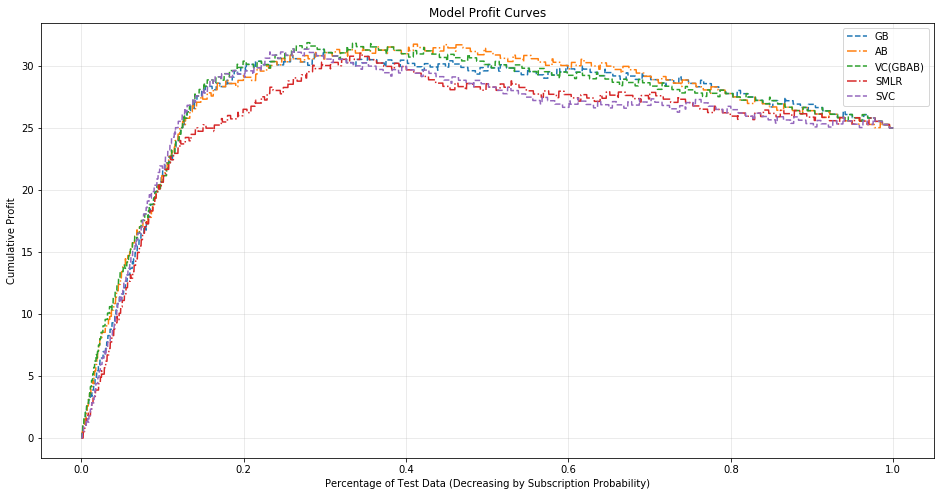

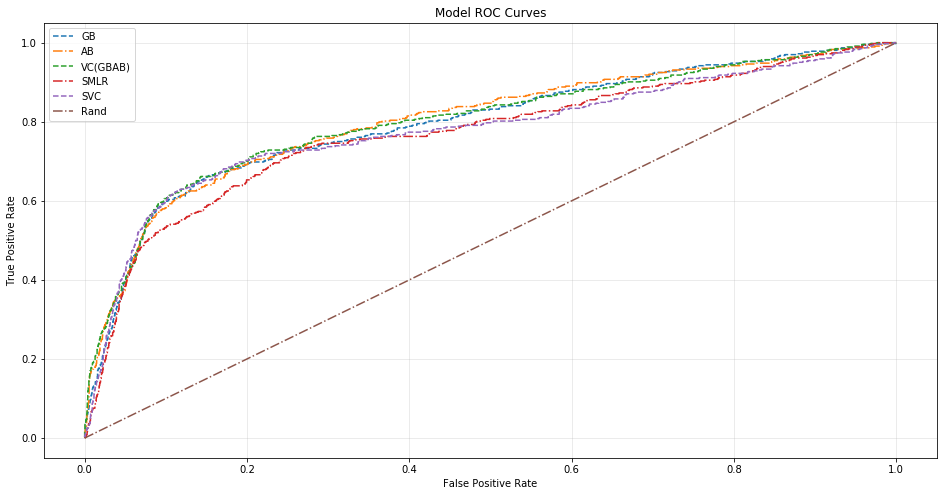

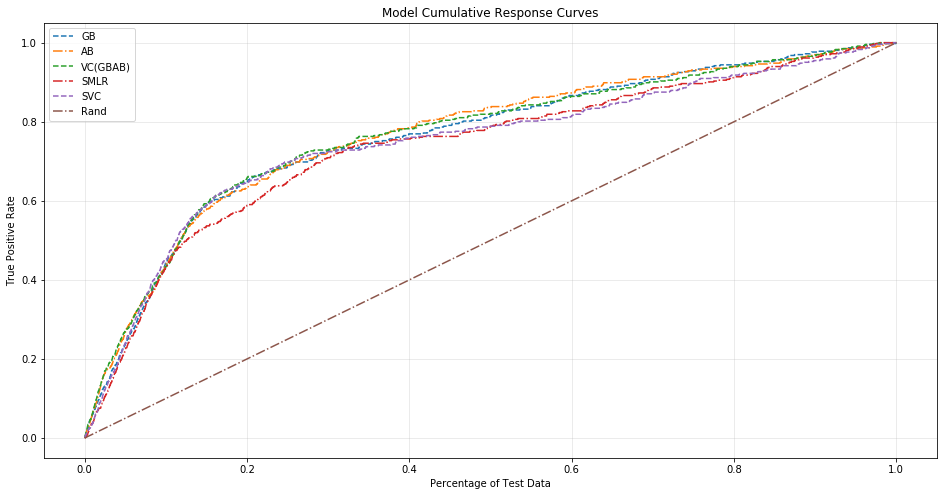

C:\Users\jakee\Anaconda3\lib\site-packages\ipykernel_launcher.py:340: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jakee\Anaconda3\lib\site-packages\ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jakee\Anaconda3\lib\site-packages\ipykernel_launcher.py:344: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jakee\Anaconda3\lib\site-packages\ipykernel_launcher.py:346: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\jakee\Anaconda3\lib\site-packages\ipykernel_launcher.py:348: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\jakee\Anaconda3\lib\site-packages\ipykernel_launcher.py:350: RuntimeWarning: divide by zero encountered in double_scalars


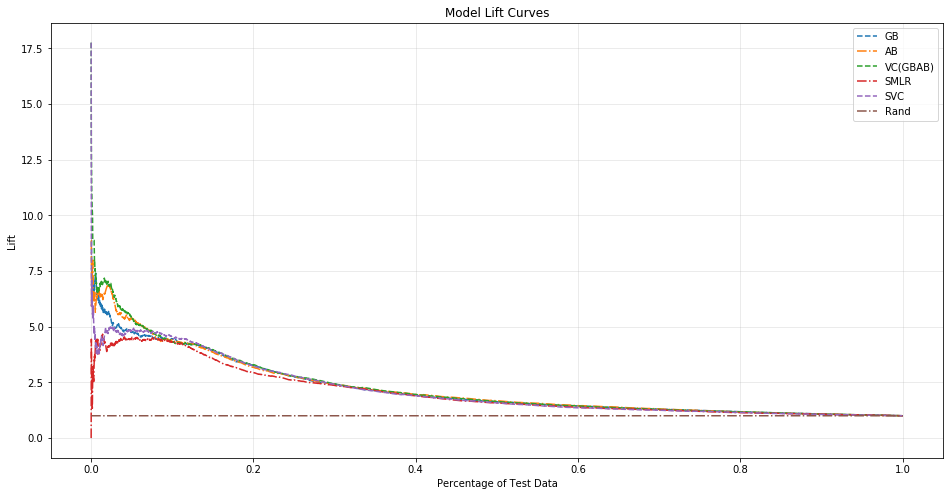

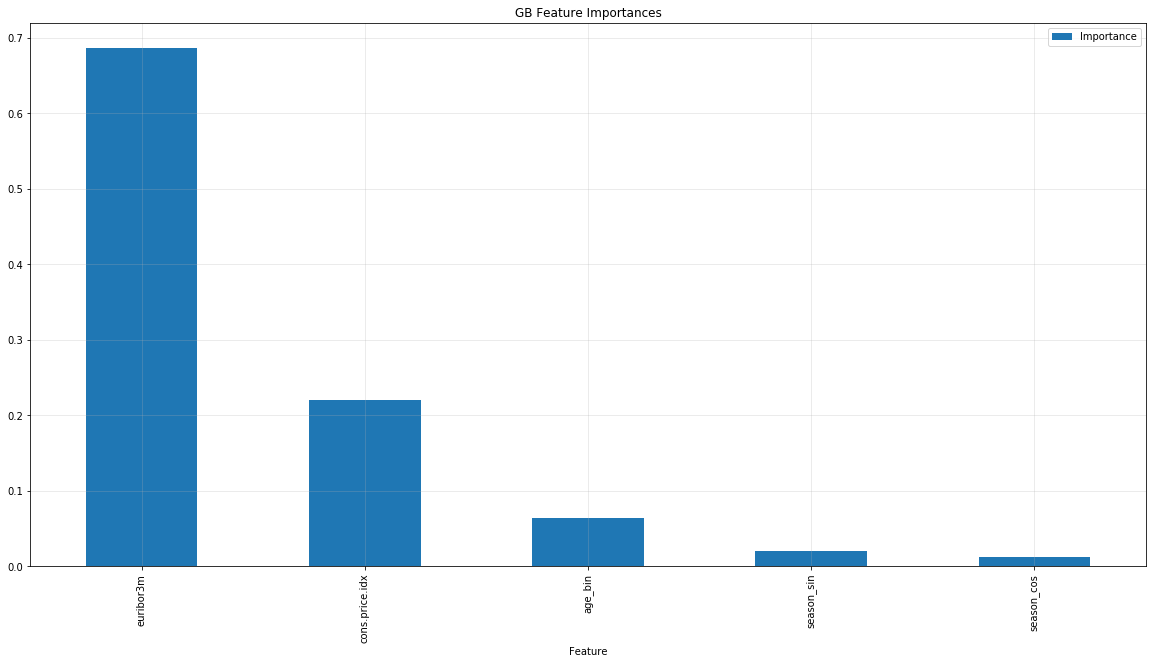

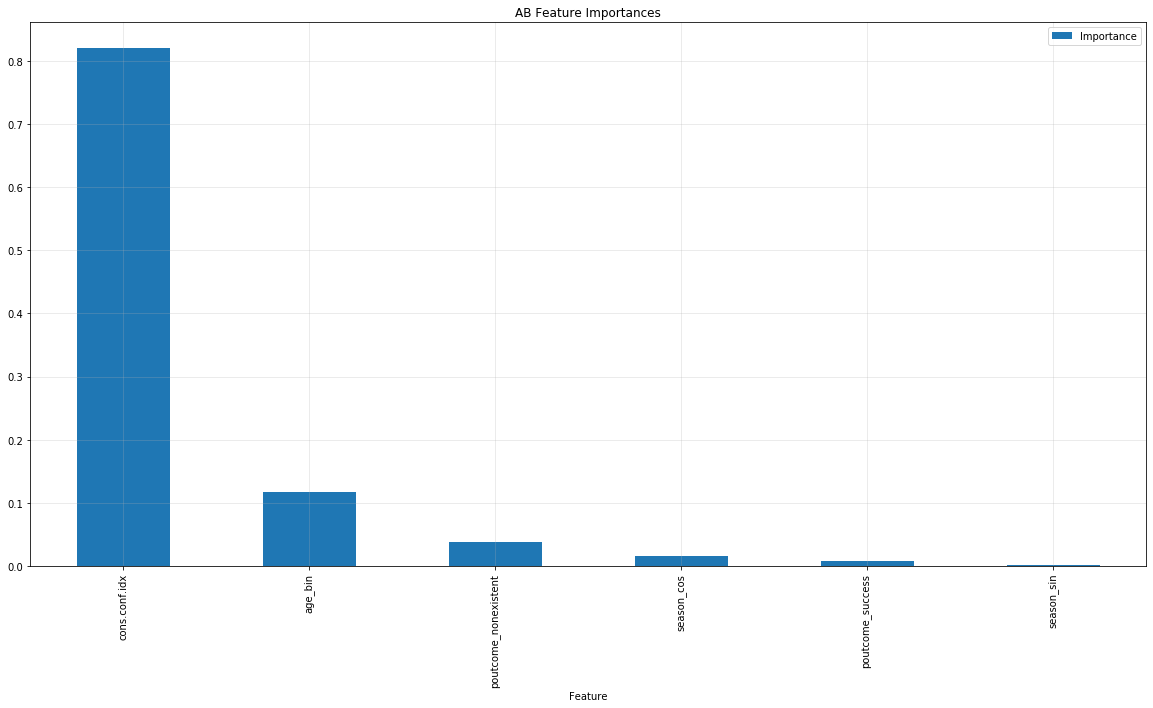

In [63]:
# final model evaluation and plots
# load data
classif_train_feats, classif_train_targ = load_data(features)
classif_test_feats, classif_test_targ = load_data(hold_data)

# optimal model features
gb_train_feats, ab_train_feats, vc_train_feats, smlr_train_feats, svc_train_feats = get_optimal_model_features(classif_train_feats)
gb_test_feats, ab_test_feats, vc_test_feats, smlr_test_feats, svc_test_feats = get_optimal_model_features(classif_test_feats)
# one hot encode train/test
gb_train_feats = pd.get_dummies(gb_train_feats, drop_first = True)
gb_test_feats = pd.get_dummies(gb_test_feats, drop_first = True)
ab_train_feats = pd.get_dummies(ab_train_feats, drop_first = True)
ab_test_feats = pd.get_dummies(ab_test_feats, drop_first = True)
vc_train_feats = pd.get_dummies(vc_train_feats, drop_first = True)
vc_test_feats = pd.get_dummies(vc_test_feats, drop_first = True)
svc_train_feats = pd.get_dummies(svc_train_feats, drop_first = True)
svc_test_feats = pd.get_dummies(svc_test_feats, drop_first = True)

# initiate scaler
sc = StandardScaler(with_mean = False)

# get  classification models
classif_models, classif_names = get_classif_models()

# get sampling models
svms, smote, rus, vc_smote = get_sampling_models()

# expected model profit
gbdt_profit_scores = []
abdt_profit_scores = []
vcdt_profit_scores = []
smlr_profit_scores = []
svc_profit_scores = []

gb_tp_rate = []
gb_fp_rate = []
ab_tp_rate = []
ab_fp_rate = []
vc_tp_rate = []
vc_fp_rate = []
smlr_tp_rate = []
smlr_fp_rate = []
svc_tp_rate = []
svc_fp_rate = []

model_avg_scores = []
model_std_scores = []
test_eval_scores = []
model_rocauc_scores = []


# test data percentage for plotting
gb_testdata_percentages = []
ab_testdata_percentages = []
vc_testdata_percentages = []
smlr_testdata_percentages = []
svc_testdata_percentages = []

testdata_percentages = []
for i in range(len(hold_data)):
    perc = (i + 1) / len(hold_data)
    testdata_percentages.append(perc)

model_profit_dict = {'Model': [], 'Expected Profit': []}
model_cost_dict = {'Model': [], 'Expected Cost': []}

clf_models = []
model_fi = []

""" models: GB/DT, AB/DT, VC/DT """    

for i in range(len(classif_models)):
    clf_models.append(classif_names[i])
    if classif_names[i] == 'GB':
        clf_train_feats = gb_train_feats
        clf_test_feats = gb_test_feats
        clf_pipe = Pipeline(steps = [('scaler', sc), ('oversample', svms), ('model', classif_models[i])])
    elif classif_names[i] == 'AB':
        clf_train_feats = ab_train_feats
        clf_test_feats = ab_test_feats
        clf_pipe = Pipeline(steps = [('scaler', sc), ('oversample', smote), ('undersample', rus), ('model', classif_models[i])])
    elif classif_names[i] == 'VC(GBAB)':
        clf_train_feats = vc_train_feats
        clf_test_feats = vc_test_feats
        clf_pipe = Pipeline(steps = [('scaler', sc), ('oversample', vc_smote), ('undersample', rus), ('model', classif_models[i])])
    elif classif_names[i] == 'SM LR':
        clf_train_feats = smlr_train_feats
        clf_test_feats = smlr_test_feats
        clf_pipe = Pipeline(steps = [('model', classif_models[i])])
    else:
        clf_train_feats = svc_train_feats
        clf_test_feats = svc_test_feats
        clf_pipe = Pipeline(steps = [('scaler', sc), ('oversample', svms), ('pca', PCA(n_components = 12)), ('model', classif_models[i])])
    
    clf_index = clf_test_feats.index.to_list()

    print(f'\nProcessing {classif_names[i]} model')

    # fit & predict clf pipeline
    clf_pipe.fit(clf_train_feats, classif_train_targ)
    clf_probs = clf_pipe.predict_proba(clf_test_feats)[:,1]
    clf_pred = clf_pipe.predict(clf_test_feats)

    # feature importances
    if classif_names[i] in ['GB','AB']:
        if classif_names[i] == 'GB':
            importances = clf_pipe.steps[2][1].feature_importances_
        elif classif_names[i] == 'AB':
            importances = clf_pipe.steps[3][1].feature_importances_
        feature_importances = pd.DataFrame({'Feature': clf_train_feats.columns, 'Importance': importances})
        feature_importances.sort_values(by = 'Importance', ascending = False, inplace = True)
        feature_importances.set_index('Feature', inplace = True, drop = True)
        model_fi.append(feature_importances)

    # evaluate models
    model_scores = evaluate_model(clf_train_feats, classif_train_targ, clf_pipe)
    model_avg_scores.append(np.mean(model_scores))
    model_std_scores.append(np.std(model_scores))

    # fbeta
    test_fbeta = f2(classif_test_targ, clf_pred)
    test_eval_scores.append(test_fbeta)

    # roc auc
    roc_auc = roc_auc_score(classif_test_targ, clf_pred)
    model_rocauc_scores.append(roc_auc)

    # classifier confusion matrix
    con_mat = confusion_matrix(classif_test_targ,clf_pred)
    cm = pd.DataFrame(con_mat, index = ['A_Neg', 'A_Pos'], columns = ['P_Neg', 'P_Pos'])
    print(f'\n{classif_names[i]} Confusion Matrix:\n{cm}')

    # profit curve
    prob_df = clf_test_feats.copy()
    prob_df['Client Index'] = clf_index
    prob_df['Actual Class'] = classif_test_targ.values
    prob_df['Pred Class'] = clf_pred
    prob_df['Pred Subscription Probs'] = clf_probs

    prob_df.sort_values(by = 'Pred Subscription Probs', ascending = False, inplace = True)

    # model profit curve/roc for model
    cls = classif_test_targ.value_counts()
    pos = cls[1]
    neg = cls[0]
    threshold_matrix = np.array([[neg, 0],[pos, 0]])
    for r in range(len(prob_df)):
        tdp = (r + 1) / len(prob_df)
        if classif_names[i] == 'GB':
            gb_testdata_percentages.append(tdp)
        elif classif_names[i] == 'AB':
            ab_testdata_percentages.append(tdp)
        elif classif_names[i] == 'VC(GBAB)':
            vc_testdata_percentages.append(tdp)
        elif classif_names[i] == 'SM LR':
            smlr_testdata_percentages.append(tdp)
        else:
            svc_testdata_percentages.append(tdp)
        row = prob_df.iloc[r,:]
        if row['Actual Class'] == 1:
            threshold_matrix[1,0] -= 1
            threshold_matrix[1,1] += 1
        else:
            threshold_matrix[0,0] -= 1
            threshold_matrix[0,1] += 1

        est_costs = 30 # advertisements/emails/employees time
        sub_prob = row['Pred Subscription Probs']
        deposit_val = 500
        # predict expected value of client
        client_cb_matrix = np.array([[0,  -est_costs],
                                     [0,  deposit_val-est_costs]]) 
        # expected profit & value
        exp_prof = expected_value(threshold_matrix, client_cb_matrix)
        if classif_names[i] == 'GB':
            gbdt_profit_scores.append(exp_prof)
        elif classif_names[i] == 'AB':
            abdt_profit_scores.append(exp_prof)
        elif classif_names[i] == 'VC(GBAB)':
            vcdt_profit_scores.append(exp_prof)
        elif classif_names[i] == 'SM LR':
            smlr_profit_scores.append(exp_prof)
        else:
            svc_profit_scores.append(exp_prof)

        # roc rates
        fp_rate = threshold_matrix[0,1] / neg
        tp_rate = threshold_matrix[1,1] / pos
        if classif_names[i] == 'GB':
            gb_tp_rate.append(tp_rate)
            gb_fp_rate.append(fp_rate)
        elif classif_names[i] == 'AB':
            ab_tp_rate.append(tp_rate)
            ab_fp_rate.append(fp_rate)
        elif classif_names[i] == 'VC(GBAB)':
            vc_tp_rate.append(tp_rate)
            vc_fp_rate.append(fp_rate)
        elif classif_names[i] == 'SM LR':
            smlr_tp_rate.append(tp_rate)
            smlr_fp_rate.append(fp_rate)
        else:
            svc_tp_rate.append(tp_rate)
            svc_fp_rate.append(fp_rate)

    client_probs_df = prob_df[['Client Index', 'Pred Subscription Probs']]
    client_probs_df.to_csv(f'{classif_names[i]}_client_profit_df.csv')

    # expected model profits dataframe
    mod_prof = expected_value(con_mat, client_cb_matrix)
    if classif_names[i] == 'GB':
        model_profit_dict['Model'].append(f'{classif_names[i]}')
        model_profit_dict['Expected Profit'].append(mod_prof)
    elif classif_names[i] == 'AB':
        model_profit_dict['Model'].append(f'{classif_names[i]}')
        model_profit_dict['Expected Profit'].append(mod_prof)
    elif classif_names[i] == 'VC(GBAB)':
        model_profit_dict['Model'].append(f'{classif_names[i]}')
        model_profit_dict['Expected Profit'].append(mod_prof)
    elif classif_names[i] == 'SM LR':
        model_profit_dict['Model'].append(f'{classif_names[i]}')
        model_profit_dict['Expected Profit'].append(mod_prof)
    else:
        model_profit_dict['Model'].append(f'{classif_names[i]}')
        model_profit_dict['Expected Profit'].append(mod_prof)

    joblib.dump(clf_pipe, f'{classif_names[i]}_model_pipeline.sav')
    
# model profit dataframe
model_profit_df = pd.DataFrame(model_profit_dict)
model_profit_df.sort_values(by = 'Expected Profit', ascending = False, inplace = True, ignore_index = True)
print(f'\n{model_profit_df}')

# model metrics dataframe
model_metrics = pd.DataFrame(
    {'Model': clf_models,
     'Avg Fbeta': model_avg_scores,
     'Std': model_std_scores,
     'Test Fbeta': test_eval_scores,
     'ROC AUC': model_rocauc_scores
    }
)
# save/print metrics
model_metrics.to_csv(r'clf_model_metrics.csv')
print(f'\nModel Metrics:\n{model_metrics}')

# plot profit curve
plt.figure(figsize = (16,8))
plt.plot(gb_testdata_percentages, gbdt_profit_scores, label = 'GB', linestyle = '--')
plt.plot(ab_testdata_percentages, abdt_profit_scores, label = 'AB', linestyle = '-.')
plt.plot(vc_testdata_percentages, vcdt_profit_scores, label = 'VC(GBAB)', linestyle = '--')
plt.plot(smlr_testdata_percentages, smlr_profit_scores, label = 'SMLR', linestyle = '-.')
plt.plot(svc_testdata_percentages, svc_profit_scores, label = 'SVC', linestyle = '--')
plt.title('Model Profit Curves')
plt.xlabel('Percentage of Test Data (Decreasing by Subscription Probability)')
plt.ylabel('Cumulative Profit')
plt.grid(alpha = 0.3)
plt.legend()
plt.savefig('model_profit_curves.png')
plt.show()

rand_x = np.linspace(0.0,1.0,len(classif_test_feats))
rand_y = np.linspace(0.0,1.0,len(classif_test_feats))

# plot ROC Curve
plt.figure(figsize = (16,8))
plt.plot(gb_fp_rate, gb_tp_rate, label = 'GB', linestyle = '--')
plt.plot(ab_fp_rate, ab_tp_rate, label = 'AB', linestyle = '-.')
plt.plot(vc_fp_rate, vc_tp_rate, label = 'VC(GBAB)', linestyle = '--')
plt.plot(smlr_fp_rate, smlr_tp_rate, label = 'SMLR', linestyle = '-.')
plt.plot(svc_fp_rate, svc_tp_rate, label = 'SVC', linestyle = '--')
plt.plot(rand_x, rand_y, label = 'Rand', linestyle = '-.')
plt.title('Model ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha = 0.3)
plt.legend()
plt.savefig('model_roc_curves.png')
plt.show()

# plot cumulative respones curve
plt.figure(figsize = (16,8))
plt.plot(gb_testdata_percentages, gb_tp_rate, label = 'GB', linestyle = '--')
plt.plot(ab_testdata_percentages, ab_tp_rate, label = 'AB', linestyle = '-.')
plt.plot(vc_testdata_percentages, vc_tp_rate, label = 'VC(GBAB)', linestyle = '--')
plt.plot(smlr_testdata_percentages, smlr_tp_rate, label = 'SMLR', linestyle = '-.')
plt.plot(svc_testdata_percentages, svc_tp_rate, label = 'SVC', linestyle = '--')
plt.plot(rand_x, rand_y, label = 'Rand', linestyle = '-.')
plt.title('Model Cumulative Response Curves')
plt.xlabel('Percentage of Test Data')
plt.ylabel('True Positive Rate')
plt.grid(alpha = 0.3)
plt.legend()
plt.savefig('cumulative_response_curves.png')
plt.show()

# lift curve
gb_lift_vals = []
rand_lift_vals = []
smlr_lift_vals = []
ab_lift_vals = []
vc_lift_vals = []
svc_lift_vals = []
for i in range(len(gb_tp_rate)):
    gb_lv = gb_tp_rate[i] / rand_y[i] #rand_tp_rate[i]
    gb_lift_vals.append(gb_lv)
    rand_lv = rand_y[i] / rand_y[i]
    rand_lift_vals.append(rand_lv)
    smlr_lv = smlr_tp_rate[i] / rand_y[i]
    smlr_lift_vals.append(smlr_lv)
    ab_lv = ab_tp_rate[i] / rand_y[i]
    ab_lift_vals.append(ab_lv)
    vc_lv = vc_tp_rate[i] / rand_y[i]
    vc_lift_vals.append(vc_lv)
    svc_lv = svc_tp_rate[i] / rand_y[i]
    svc_lift_vals.append(svc_lv)
plt.figure(figsize = (16,8))
plt.plot(gb_testdata_percentages, gb_lift_vals, label = 'GB', linestyle = '--')
plt.plot(ab_testdata_percentages, ab_lift_vals, label = 'AB', linestyle = '-.')
plt.plot(vc_testdata_percentages, vc_lift_vals, label = 'VC(GBAB)', linestyle = '--')
plt.plot(smlr_testdata_percentages, smlr_lift_vals, label = 'SMLR', linestyle = '-.')
plt.plot(svc_testdata_percentages, svc_lift_vals, label = 'SVC', linestyle = '--')
plt.plot(testdata_percentages, rand_lift_vals, label = 'Rand', linestyle = '-.')
plt.title('Model Lift Curves')
plt.xlabel('Percentage of Test Data')
plt.ylabel('Lift')
plt.grid(alpha = 0.3)
plt.legend()
plt.savefig('model_lift_curves.png')
plt.show()

# plot feature importances
for i in range(len(clf_models)):
    if clf_models[i] in ['GB','AB']:
        model_fi[i].plot.bar(figsize = (20,10))
        plt.title(f'{clf_models[i]} Feature Importances')
        plt.grid(alpha = 0.3)
        plt.savefig(f'{clf_models[i]}_feature_importances.png')
        plt.show()
    else:
        continue

If we were to target everyone that is predicted to subscribe our simple linear regression model produces the highest average profit per client at £30.53. From the model profit graph we can see that if we instead target approximately the top 25% of clients with the highest probabilty of subscribing, with our voting classifier we can increase profits by approximately 8% over the simple model and achieve a profit of approximately £33 per client. The voting classifier also increases profits by 32% over targeting everyone.

Amount of data: 5000
Amount of data: 10000
Amount of data: 15000
Amount of data: 20000
Amount of data: 25000
Amount of data: 30000
Amount of data: 35000


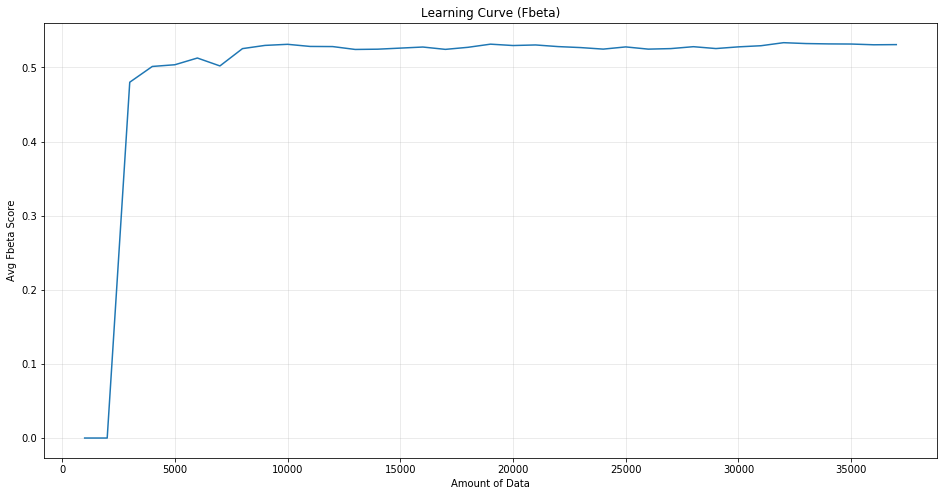

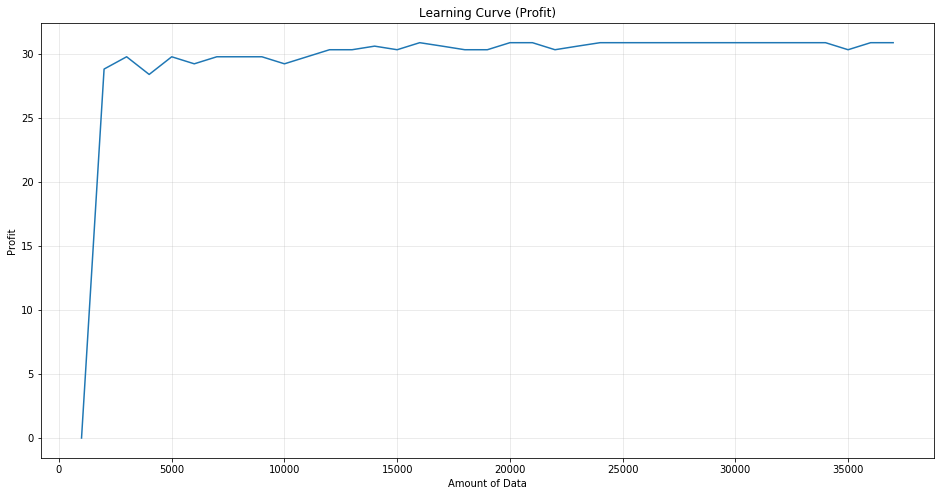

In [68]:
# learnng curve of final model.. fbeta & profit
num_data = []
avg_scores = []
profit = []

for i in range(1000, 37001, 1000):
    if i % 5000 == 0:
        print(f'Amount of data: {i}')
    # load data
    train_feats, train_targ = load_data(features)
    hold_feats, hold_targ = load_data(hold_data)
    
    # crop features/target
    train_feats = train_feats.iloc[:i, :]
    train_targ = train_targ.iloc[:i]
    hold_feats = hold_feats.iloc[:i, :]
    hold_targ = hold_targ.iloc[:i]
    
    train_feats, train_targ = shuffle(train_feats, train_targ)

    sub_train_feats = train_feats[
        [
            'age_bin',  
            'previous', 
            'poutcome', 
            'emp.var.rate',
            'euribor3m', 
            'nr.employed',  
            'season_sin', 
            'season_cos',
        ]
    ] 
    
    sub_hold_feats = hold_feats[
        [
            'age_bin',  
            'previous', 
            'poutcome', 
            'emp.var.rate',
            'euribor3m', 
            'nr.employed',  
            'season_sin', 
            'season_cos',
        ]
    ] 

    # one hot encode data
    sub_train_feats = pd.get_dummies(sub_train_feats, drop_first = True)
    sub_hold_feats = pd.get_dummies(sub_hold_feats, drop_first = True)

    # define oss sampling and scaler ############### change
    rus = RandomUnderSampler(sampling_strategy = 0.6)
    vc_smote = SMOTE(sampling_strategy = 0.4, k_neighbors = 5)
    sc = StandardScaler(with_mean = False)

    # define model
    gb = GradientBoostingClassifier(
        learning_rate = 0.05,
        n_estimators = 250,
        max_depth = 9,
        min_samples_split = 1500,
        min_samples_leaf = 140,
        max_features = 3,
        subsample = 0.8,
        random_state = 42
    )
    ab = AdaBoostClassifier(
        algorithm = 'SAMME.R',
        learning_rate = 0.75,
        n_estimators = 450,
        random_state = 42
    )
    
    model = VotingClassifier([('gb', gb), ('ab', ab)], voting = 'soft', n_jobs = -1)

    pipeline = Pipeline(
        steps = [
            ('scaler', sc), 
            ('oversample', vc_smote), 
            ('undersample', rus), 
            ('model', model)
        ]
    )
    
    # fbeta scores
    scores = evaluate_model(sub_train_feats, train_targ, pipeline)
    # fit pipeline
    pipeline.fit(sub_train_feats, train_targ)
    hold_pred = pipeline.predict(sub_hold_feats)
    # cm & cb matrices
    con_mat = confusion_matrix(hold_targ, hold_pred)
    cb_matrix = np.array([[0,-30],[0,500]])
    # expected profit
    exp_val = expected_value(con_mat, cb_matrix)
    # append lists
    profit.append(exp_val)
    num_data.append(i)
    avg_scores.append(np.mean(scores))

# plot learning curve for fbeta
plt.figure(figsize = (16, 8))
plt.plot(num_data, avg_scores)
plt.grid(alpha = 0.3)
plt.title('Learning Curve (Fbeta)')
plt.xlabel('Amount of Data')
plt.ylabel('Avg Fbeta Score')
plt.show()
# plot learning curve for profit
plt.figure(figsize = (16, 8))
plt.plot(num_data, profit)
plt.grid(alpha = 0.3)
plt.title('Learning Curve (Profit)')
plt.xlabel('Amount of Data')
plt.ylabel('Profit')
plt.show()